<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM%20-%20Full%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (313/313), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 393 (delta 105), reused 181 (delta 41), pack-reused 80 (from 1)
Receiving objects: 100% (393/393), 256.29 MiB | 34.84 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Updating files: 100% (59/59), done.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import optuna

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import register_keras_serializable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

es1 = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

es2 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

es3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [6]:
test_df = pd.read_csv('../../data/processed/processed_full.csv')
test_df.shape

(3652, 38)

In [7]:
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2010-01-01          1          0          0          0          0   
1     2010-01-02          1          0          0          0          0   
2     2010-01-03          1          0          0          0          1   
3     2010-01-04          1          0          0          0          0   
4     2010-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
3647  2019-12-27          1          0          0          0          0   
3648  2019-12-28          1          0          0          0          0   
3649  2019-12-29          1          0          0          0          1   
3650  2019-12-30          1          0          0          0          0   
3651  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
3647          0           0             0            0  ...   
3648          0           0             0            0  ...   
3649          0           0             0            0  ...   
3650          1           0             0            0  ...   
3651          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               8883.98          374464.94                   48  25.094000   
1               9294.07          384838.07                   48  24.765385   
2               8247.61          355195.18                   48  19.429825   
3               9468.92          395602.57                   48  20.625926   
4              10687.29          423735.03                   48  22.660417   
...                 ...                ...                  ...        ...   
3647            9324.59          360393.59                   48  23.654717   
3648            9806.43          369325.03                   48  24.309615   
3649            9773.20          371819.56                   48  23.689583   
3650           10848.99          399427.25                   48  24.172917   
3651           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         22.1      28.8          0.0     5.594000            NaN       NaN  
1         21.6      29.4          0.0     5.265385            NaN       NaN  
2         17.9      21.5          0.0     0.000000            NaN       NaN  
3         17.9      23.9          0.0     1.125926            NaN       NaN  
4         15.4      27.7          0.0     3.160417            NaN       NaN  
...        ...       ...          ...          ...            ...       ...  
3647      19.2      28.5          0.0     4.154717       0.081469      30.7  
3648      16.6      29.9          0.0     4.809615       0.571150      30.8  
3649      18.1      29.3          0.0     4.189583       0.101862      21.8  
3650      18.1      31.0          0.0     4.672917       0.243804      26.3  
3651      17.7      42.1          0.0     6.805882       1.126134      27.7  

[3652 rows x 38 columns]

In [8]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2010-01-01           1          0          0          0          0          0   
2010-01-02           1          0          0          0          0          0   
2010-01-03           1          0          0          0          1          0   
2010-01-04           1          0          0          0          0          1   
2010-01-05           1          0          0          0          0          0   
2010-01-06           1          0          0          0          0          0   
2010-01-07           1          0          0          0          0          0   
2010-01-08           1          0          0          0          0          0   
2010-01-09           1          0          0          0          0          0   
2010-01-10           1          0          0          0          1          0   
2010-01-11           1          0          0          0          0          1   
2010-01-12           1          0          0          0          0          0   
2010-01-13           1          0          0          0          0          0   
2010-01-14           1          0          0          0          0          0   
2010-01-15           1          0          0          0          0          0   
2010-01-16           1          0          0          0          0          0   
2010-01-17           1          0          0          0          1          0   
2010-01-18           1          0          0          0          0          1   
2010-01-19           1          0          0          0          0          0   
2010-01-20           1          0          0          0          0          0   
2010-01-21           1          0          0          0          0          0   
2010-01-22           1          0          0          0          0          0   
2010-01-23           1          0          0          0          0          0   
2010-01-24           1          0          0          0          1          0   
2010-01-25           1          0          0          0          0          1   
2010-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2010-01-01            0             0            0          1  ...   
2010-01-02            0             0            0          0  ...   
2010-01-03            0             0            0          0  ...   
2010-01-04            0             0            0          0  ...   
2010-01-05            1             0            0          0  ...   
2010-01-06            0             1            0          0  ...   
2010-01-07            0             0            1          0  ...   
2010-01-08            0             0            0          1  ...   
2010-01-09            0             0            0          0  ...   
2010-01-10            0             0            0          0  ...   
2010-01-11            0             0            0          0  ...   
2010-01-12            1             0            0          0  ...   
2010-01-13            0             1            0          0  ...   
2010-01-14            0             0            1          0  ...   
2010-01-15            0             0            0          1  ...   
2010-01-16            0             0            0          0  ...   
2010-01-17            0             0            0          0  ...   
2010-01-18            0             0            0          0  ...   
2010-01-19            1             0            0          0  ...   
2010-01-20            0             1            0          0  ...   
2010-01-21            0             0            1          0  ...   
2010-01-22            0             0            0          1  ...   
2010-01-23            0             0            0          0  .

In [9]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## Helper Functions ##

In [17]:
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1]), self._get_year_slice(years[2]), self._get_year_slice(years[3]), self._get_year_slice(years[4]), self._get_year_slice(years[5]), self._get_year_slice(years[6])])
            val_df = pd.concat(self._get_extended_slice(years[7], years[6]), self._get_extended_slice(years[8], years[7]))
            test_df = self._get_extended_slice(years[9], years[8])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1]), self._get_year_slice(years[2]), self._get_year_slice(years[3]), self._get_year_slice(years[4]), self._get_year_slice(years[5]), self._get_year_slice(years[6])])
            val_df = pd.concat([self._get_year_slice(years[7]), self._get_year_slice(years[8])])
            test_df = self._get_year_slice(years[9])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def to_X_and_y(self, df_scaled, target_col='avg_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 8 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2]),
            self._get_year_slice(years[3]),
            self._get_year_slice(years[4]),
            self._get_year_slice(years[5]),
            self._get_year_slice(years[6]),
            self._get_year_slice(years[7]),
            self._get_year_slice(years[8])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[9])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs


### Setup function for printing, metrics ###

In [11]:
## Optuna Function
def objective(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train20.shape[1], X_train20.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train20, y_train20, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

In [12]:
## Tweaked Optuna function for early stopping, etc.

def objective2(trial):
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    n_units1 = trial.suggest_int("n_units1", 32, 128)
    n_units2 = trial.suggest_int("n_units2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    stacked = trial.suggest_categorical("stacked", [False, True])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        if stacked:
            model.add(LSTM(n_units1, return_sequences=True, dropout=dropout))
            model.add(LSTM(n_units2, dropout=dropout))
        else:
            model.add(LSTM(n_units1, dropout=dropout))

        model.add(Dense(8, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        checkpoint_path = f"trial_{trial.number}_best.keras"
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                            save_best_only=True, save_weights_only=False, verbose=0)
        ]

        history = model.fit(
            X_train20, y_train20,
            epochs=200,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            callbacks=callbacks,
            verbose=0
        )

        best_model = load_model(checkpoint_path)

        y_pred = best_model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: stacked={stacked}, units1={n_units1}, units2={n_units2}, "
          f"dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae

In [13]:
## Optuna Function for CNN=LSTM Hybrid ##

def objective3(trial):
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    filters = trial.suggest_int("filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    pool_size = trial.suggest_int("pool_size", 2, 3)
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        # CNN block
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))

        # LSTM block
        model.add(LSTM(lstm_units, dropout=0.013))

        # Dense head
        model.add(Dense(16, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        # Train with validation split for val_loss
        model.fit(
            X_train20, y_train20,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            verbose=0
        )

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: filters={filters}, kernel={kernel_size}, pool={pool_size}, "
          f"lstm_units={lstm_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae


In [14]:
## Final Optuna Function - include Recurrent Dropout

def objective4(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.3)

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train29.shape[1], X_train29.shape[2])),
            layers.LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train29, y_train29, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test29, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## 1. Base Model - Avg Demand Only ##

In [18]:
demandDF = test_df[['avg_30_min_demand']]

In [19]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

i = X_train.shape[1]
j = X_train.shape[2]

In [20]:
def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='avg_30_min_demand'):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [21]:
model1 = Sequential()
model1.add(InputLayer((i, j)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es1])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0513 - mean_absolute_percentage_error: 50533.2695 - root_mean_squared_error: 0.2153 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 33.9977 - val_root_mean_squared_error: 0.1054
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0098 - mean_absolute_percentage_error: 46449.0430 - root_mean_squared_error: 0.0992 - val_loss: 0.0107 - val_mean_absolute_percentage_error: 31.8807 - val_root_mean_squared_error: 0.1035
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - mean_absolute_percentage_error: 46055.7773 - root_mean_squared_error: 0.0976 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 31.3305 - val_root_mean_squared_error: 0.1029
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - mean_absolute_percentage_error: 46262.7422 - root_mean_squared_error: 0.0964 - val_loss: 0.0104 - val_mean_absolute_percentage_error: 30.9224 - val_root_mean_squared_error: 0.1021
Epoch 5

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


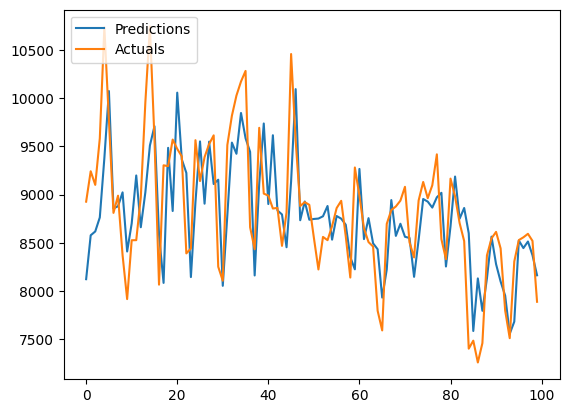

MAPE: 3.61%
RMSE: 386.32
MAE : 295.24


Predictions       Actuals
0     8122.182129   8926.811042
1     8577.680664   9242.460208
2     8617.685547   9101.040625
3     8763.248047   9584.220000
4     9377.880859  10736.342917
...           ...           ...
2545  7916.970215   7636.886458
2546  7776.262207   8261.034583
2547  8120.392090   8972.686458
2548  8382.879883   8818.212500
2549  8016.160645   8195.393125

[2550 rows x 2 columns]

In [23]:
model1 = load_model('model1.keras')

predictions_plot(model1, X_train, y_train, 0, 100, preprocessor)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


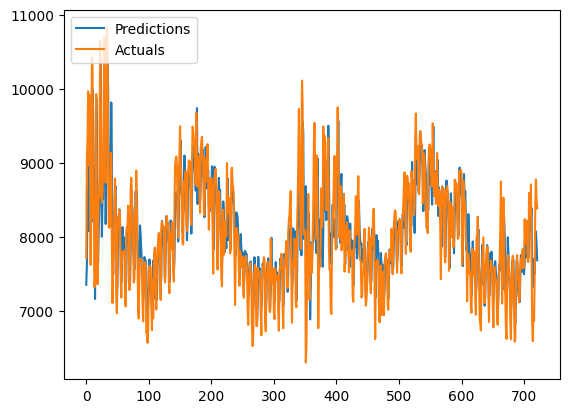

MAPE: 3.97%
RMSE: 432.27
MAE : 319.48


Predictions      Actuals
0    7347.583008  7710.001042
1    7625.734863  9080.221042
2    8614.419922  9305.965417
3    8490.284180  9962.592500
4    9102.079102  8961.122917
..           ...          ...
718  7938.263672  8447.030417
719  8068.803711  8771.408958
720  7895.191406  8487.014792
721  7677.125488  8380.489792
722  7792.645508  8437.980833

[723 rows x 2 columns]

In [25]:
predictions_plot(model1, X_val, y_val, 0, 722)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


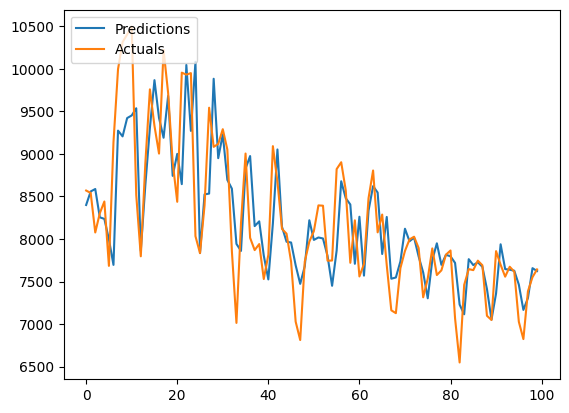

MAPE: 3.98%
RMSE: 421.46
MAE : 317.11


Predictions      Actuals
0    8399.792969  8569.568125
1    8558.918945  8540.904167
2    8587.481445  8076.513125
3    8254.681641  8302.971875
4    8236.435547  8440.820000
..           ...          ...
353  7621.920898  7508.199792
354  7715.161621  7694.271458
355  7493.260254  7746.240833
356  7592.124023  8321.401042
357  7912.452148  8503.726875

[358 rows x 2 columns]

In [26]:
predictions_plot(model1, X_test, y_test, 0, 100)

### Model 2 - Overlapping Windows ###

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

i = X_train2.shape[1]
j = X_train2.shape[2]

In [ ]:
model2 = Sequential()
model2.add(InputLayer((i, j)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1478 - root_mean_squared_error: 0.3830 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - root_mean_squared_error: 0.1659 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


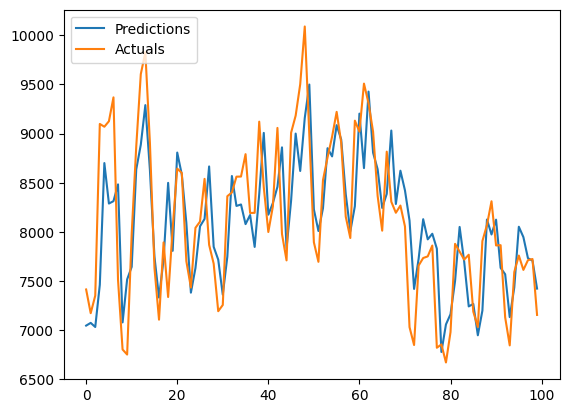

MAPE: 3.93%
RMSE: 429.05
MAE : 318.59


Predictions      Actuals
0    7044.857422  7412.811667
1    7072.628906  7171.183125
2    7030.690918  7350.264167
3    7460.327148  9098.258333
4    8700.034180  9070.002917
..           ...          ...
719  7922.685059  7374.332292
720  7883.551758  8039.583333
721  8209.938477  8575.767292
722  8429.407227  7909.507917
723  7585.711914  7144.386250

[724 rows x 2 columns]

In [ ]:
model2 = load_model('model2.keras')

predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


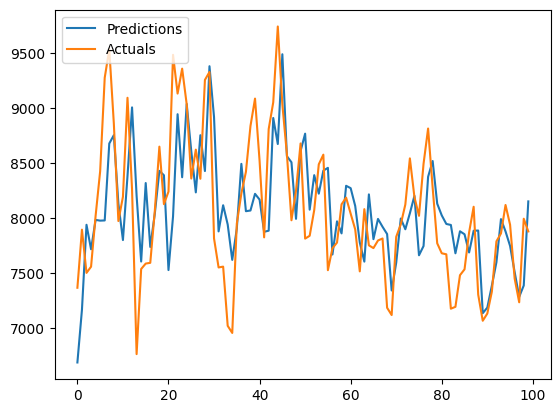

MAPE: 3.84%
RMSE: 399.79
MAE : 305.90


Predictions      Actuals
0    6685.443848  7365.989375
1    7165.174805  7895.121667
2    7939.577148  7501.373542
3    7716.687012  7557.751458
4    7984.164551  8021.308125
..           ...          ...
360  8049.064941  8447.030417
361  8139.364746  8771.408958
362  7635.950195  8487.014792
363  7553.098145  8380.489792
364  7664.180664  8437.980833

[365 rows x 2 columns]

In [ ]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


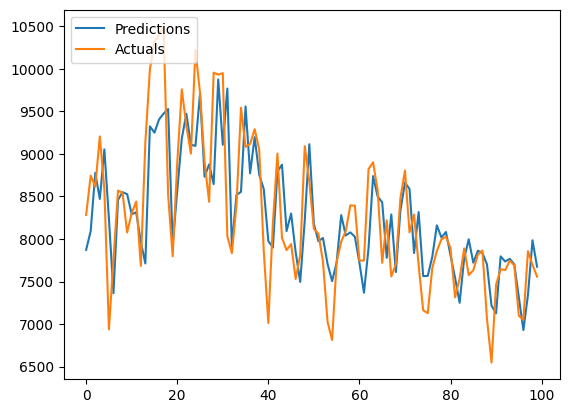

MAPE: 3.94%
RMSE: 419.20
MAE : 313.77


Predictions      Actuals
0    7872.928223  8282.850208
1    8093.322266  8745.688125
2    8776.771484  8612.550625
3    8471.083984  9205.374583
4    9053.429688  8584.935417
..           ...          ...
360  7697.467773  7508.199792
361  7806.442383  7694.271458
362  7439.136719  7746.240833
363  7584.290039  8321.401042
364  7884.499512  8503.726875

[365 rows x 2 columns]

In [ ]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

## 2. Introducing Temperature... ##

In [ ]:
tempDemandDF = test_df[['avg_30_min_demand', 'avg_temp']]

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [ ]:
model3 = Sequential()
model3.add(InputLayer((i, j)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0708 - root_mean_squared_error: 0.2602 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


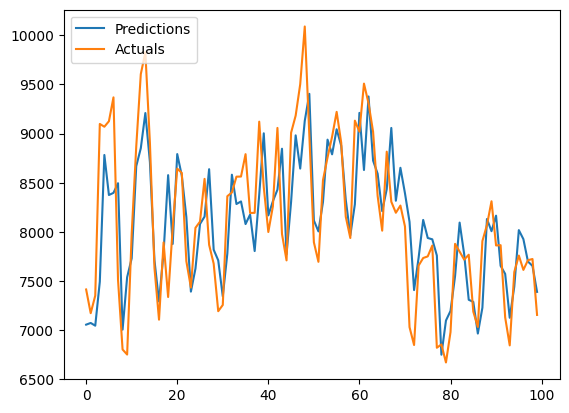

MAPE: 3.85%
RMSE: 421.94
MAE : 310.92


Predictions      Actuals
0    7054.635742  7412.811667
1    7071.848633  7171.183125
2    7044.051758  7350.264167
3    7491.594727  9098.258333
4    8782.404297  9070.002917
..           ...          ...
719  7973.373047  7374.332292
720  7927.007812  8039.583333
721  8313.372070  8575.767292
722  8516.633789  7909.507917
723  7698.170898  7144.386250

[724 rows x 2 columns]

In [ ]:
model3 = load_model('model3.keras')

predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


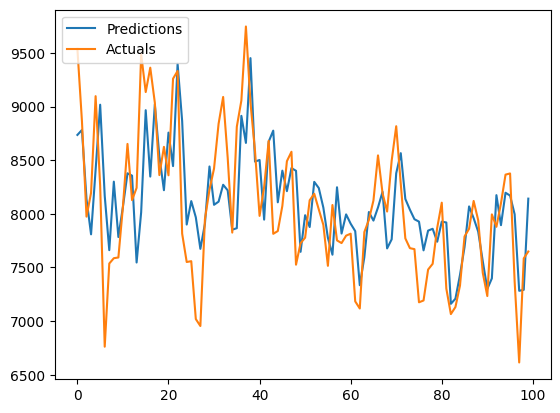

MAPE: 3.74%
RMSE: 386.34
MAE : 297.24


Predictions      Actuals
0    8735.137695  9537.097917
1    8781.397461  8863.333125
2    8137.668945  7973.787500
3    7808.852539  8194.981667
4    8409.730469  9096.434375
..           ...          ...
353  8043.074707  8447.030417
354  8276.003906  8771.408958
355  8055.455566  8487.014792
356  7722.042969  8380.489792
357  7781.282715  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


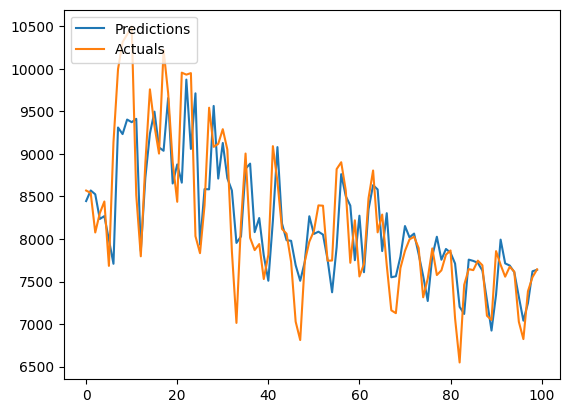

MAPE: 3.85%
RMSE: 413.28
MAE : 306.46


Predictions      Actuals
0    8445.889648  8569.568125
1    8570.495117  8540.904167
2    8525.365234  8076.513125
3    8235.282227  8302.971875
4    8269.041992  8440.820000
..           ...          ...
353  7733.142578  7508.199792
354  7905.759277  7694.271458
355  7725.211426  7746.240833
356  7815.028809  8321.401042
357  8079.720215  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

## Feature Analysis ##

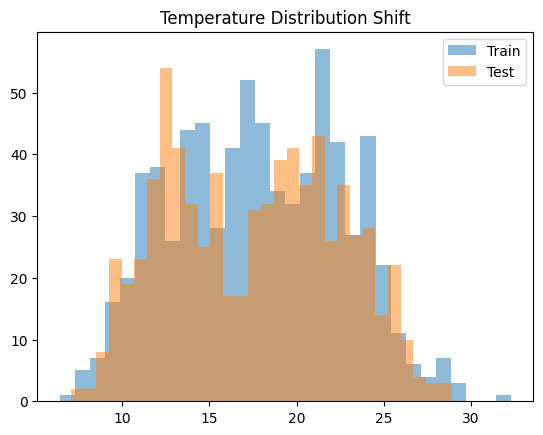

In [ ]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [ ]:
tempDemandDF2 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

## Model 4 ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

i = X_train4.shape[1]
j = X_train4.shape[2]

In [ ]:
model4 = Sequential()
model4.add(InputLayer((i, j)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1594 - root_mean_squared_error: 0.3879 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1554
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1275
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1198
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1215
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


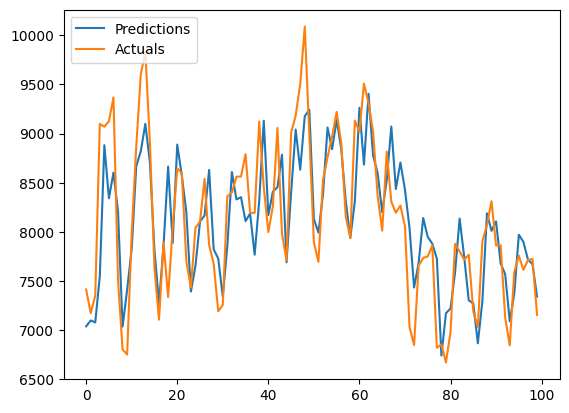

MAPE: 3.79%
RMSE: 413.44
MAE : 305.90


Predictions      Actuals
0    7037.468262  7412.811667
1    7097.260254  7171.183125
2    7077.463379  7350.264167
3    7548.653320  9098.258333
4    8881.708008  9070.002917
..           ...          ...
719  7904.533203  7374.332292
720  8025.975586  8039.583333
721  8307.371094  8575.767292
722  8458.728516  7909.507917
723  7513.947266  7144.386250

[724 rows x 2 columns]

In [ ]:
model4 = load_model('model4.keras')

predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


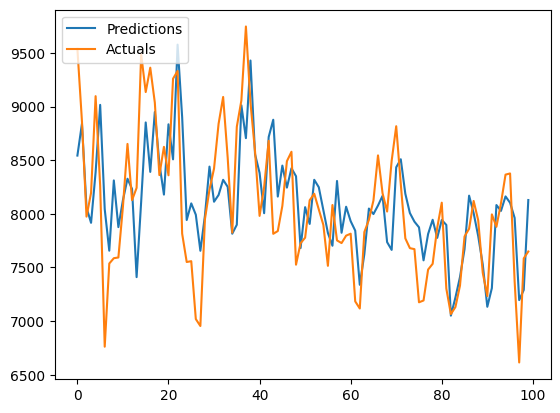

MAPE: 3.73%
RMSE: 386.13
MAE : 295.87


Predictions      Actuals
0    8542.726562  9537.097917
1    8839.429688  8863.333125
2    8058.886719  7973.787500
3    7915.928223  8194.981667
4    8387.731445  9096.434375
..           ...          ...
353  8012.182617  8447.030417
354  8371.025391  8771.408958
355  8271.087891  8487.014792
356  7783.677734  8380.489792
357  7733.641113  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


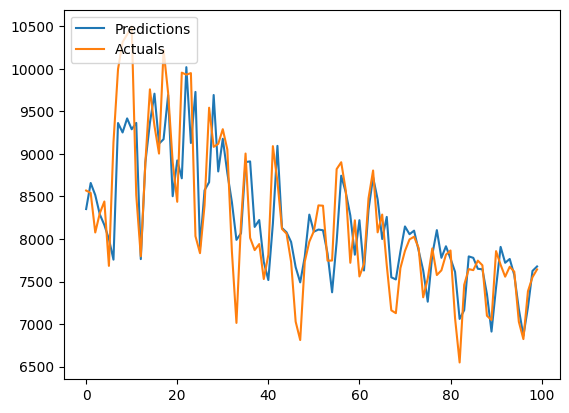

MAPE: 3.82%
RMSE: 406.74
MAE : 302.80


Predictions      Actuals
0    8352.025391  8569.568125
1    8658.270508  8540.904167
2    8516.518555  8076.513125
3    8289.468750  8302.971875
4    8164.374512  8440.820000
..           ...          ...
353  7778.042969  7508.199792
354  7892.982422  7694.271458
355  7810.985352  7746.240833
356  7823.996094  8321.401042
357  8092.445312  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

## Model 5 ##

In [29]:
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

tempDemandDF3 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

i = X_train5.shape[1]
j = X_train5.shape[2]

In [ ]:
model5 = Sequential()
model5.add(InputLayer((i, j)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0595 - root_mean_squared_error: 0.2385 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


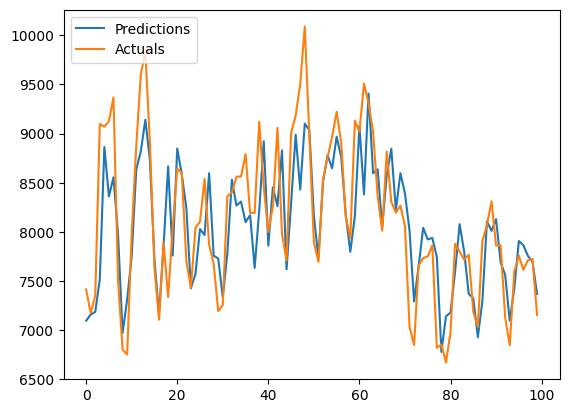

MAPE: 3.67%
RMSE: 404.18
MAE : 297.39


Predictions      Actuals
0    7094.841309  7412.811667
1    7156.830566  7171.183125
2    7184.541504  7350.264167
3    7516.354492  9098.258333
4    8863.625000  9070.002917
..           ...          ...
719  7899.138184  7374.332292
720  7922.184570  8039.583333
721  8341.222656  8575.767292
722  8571.693359  7909.507917
723  7726.886230  7144.386250

[724 rows x 2 columns]

In [ ]:
model5 = load_model('model5.keras')

predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


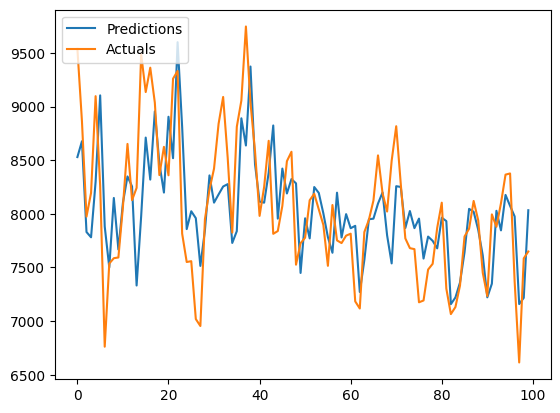

MAPE: 3.67%
RMSE: 383.24
MAE : 292.63


Predictions      Actuals
0    8528.831055  9537.097917
1    8676.096680  8863.333125
2    7830.371094  7973.787500
3    7781.238770  8194.981667
4    8299.595703  9096.434375
..           ...          ...
353  8037.048340  8447.030417
354  8364.907227  8771.408958
355  8211.406250  8487.014792
356  7726.225586  8380.489792
357  7610.937500  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


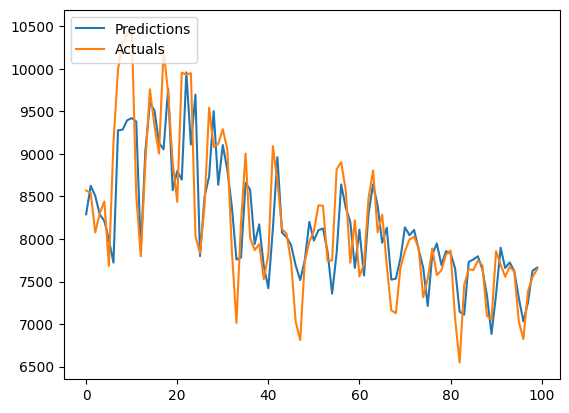

MAPE: 3.73%
RMSE: 397.55
MAE : 296.35


Predictions      Actuals
0    8290.894531  8569.568125
1    8624.436523  8540.904167
2    8507.066406  8076.513125
3    8286.613281  8302.971875
4    8213.923828  8440.820000
..           ...          ...
353  7755.895020  7508.199792
354  7908.979004  7694.271458
355  7814.226074  7746.240833
356  7899.376953  8321.401042
357  8154.214844  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

## Model 6 ##

In [ ]:
tempDemandDF4 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

i = X_train6.shape[1]
j = X_train6.shape[2]

In [ ]:
model6 = Sequential()
model6.add(InputLayer((i, j)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0513 - root_mean_squared_error: 0.2223 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0199 - root_mean_squared_error: 0.1409 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0159 - root_mean_squared_error: 0.1258 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


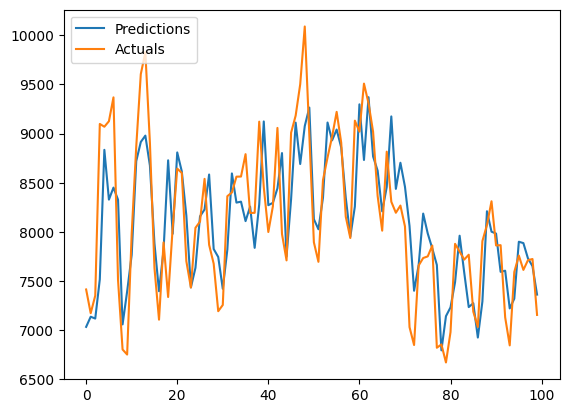

MAPE: 3.94%
RMSE: 424.51
MAE : 317.30


Predictions      Actuals
0    7031.929199  7412.811667
1    7135.335938  7171.183125
2    7116.598633  7350.264167
3    7516.220215  9098.258333
4    8834.706055  9070.002917
..           ...          ...
719  7846.251465  7374.332292
720  8064.746094  8039.583333
721  8191.898438  8575.767292
722  8204.814453  7909.507917
723  7352.442871  7144.386250

[724 rows x 2 columns]

In [ ]:
model6 = load_model('model6.keras')
predictions_plot(model6, X_train6, y_train6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


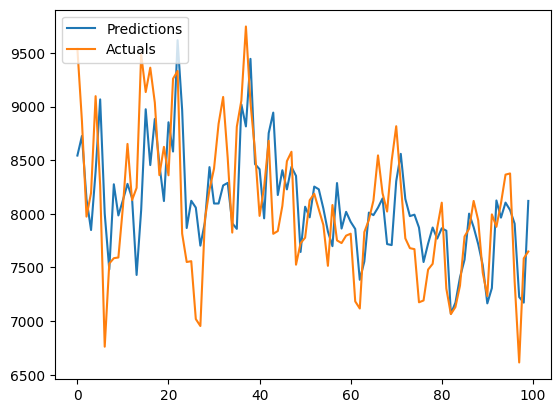

MAPE: 3.90%
RMSE: 399.84
MAE : 309.83


Predictions      Actuals
0    8542.937500  9537.097917
1    8725.531250  8863.333125
2    8137.247559  7973.787500
3    7848.955566  8194.981667
4    8395.056641  9096.434375
..           ...          ...
353  7894.423340  8447.030417
354  8205.942383  8771.408958
355  8043.650391  8487.014792
356  7661.653809  8380.489792
357  7676.969727  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


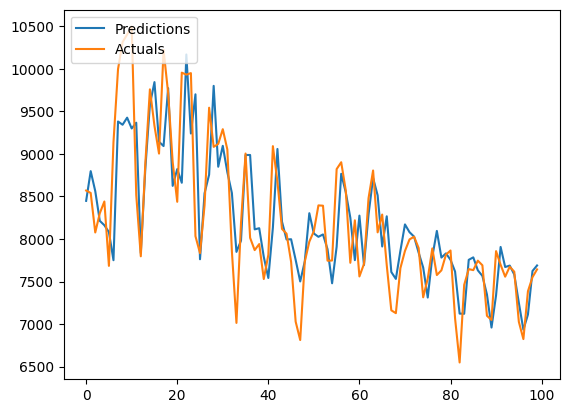

MAPE: 4.01%
RMSE: 422.82
MAE : 318.09


Predictions      Actuals
0    8448.321289  8569.568125
1    8797.657227  8540.904167
2    8562.858398  8076.513125
3    8213.212891  8302.971875
4    8161.810547  8440.820000
..           ...          ...
353  7618.266113  7508.199792
354  7753.972656  7694.271458
355  7616.751953  7746.240833
356  7619.400391  8321.401042
357  7928.664062  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

## Increase Window Size to 10 ##

## Model 7 ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

i = X_train7.shape[1]
j = X_train7.shape[2]

In [ ]:
model7 = Sequential()
model7.add(InputLayer((i, j)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0468 - root_mean_squared_error: 0.2136 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190 - root_mean_squared_error: 0.1376 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1282 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


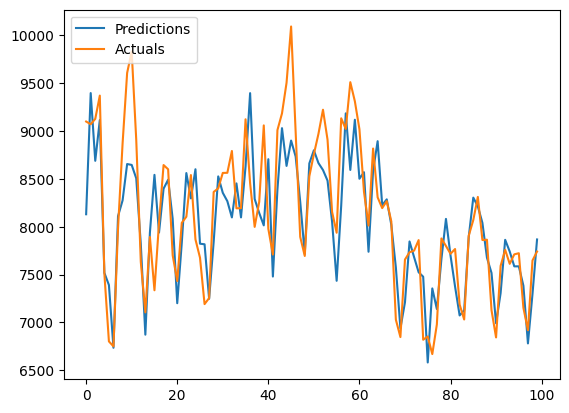

MAPE: 3.49%
RMSE: 380.25
MAE : 284.13


Predictions      Actuals
0    8129.873047  9098.258333
1    9395.404297  9070.002917
2    8687.981445  9125.678750
3    9113.805664  9368.951875
4    7518.497559  7510.325833
..           ...          ...
716  7472.602051  7374.332292
717  7769.657227  8039.583333
718  8053.329102  8575.767292
719  8290.805664  7909.507917
720  7382.060059  7144.386250

[721 rows x 2 columns]

In [ ]:
model7 = load_model('model7.keras')

predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


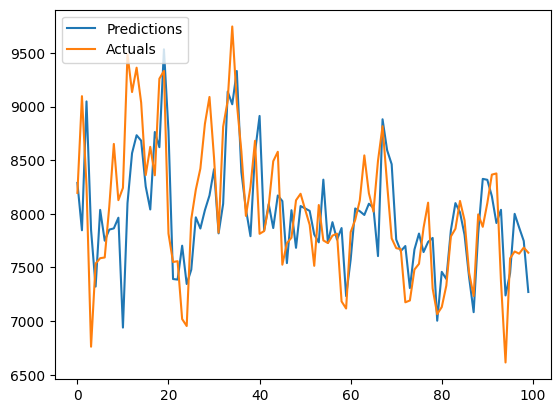

MAPE: 3.61%
RMSE: 378.85
MAE : 288.57


Predictions      Actuals
0    8287.958984  8194.981667
1    7846.690430  9096.434375
2    9047.449219  8261.405417
3    7850.677734  6761.608125
4    7321.765625  7536.762292
..           ...          ...
350  7687.997559  8447.030417
351  8198.826172  8771.408958
352  8370.680664  8487.014792
353  7872.782227  8380.489792
354  7755.987305  8437.980833

[355 rows x 2 columns]

In [ ]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


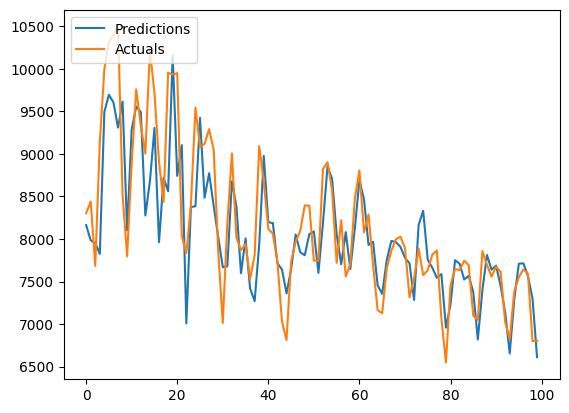

MAPE: 3.87%
RMSE: 412.63
MAE : 309.48


Predictions      Actuals
0    8163.508301  8302.971875
1    7984.119629  8440.820000
2    7952.939453  7684.176042
3    7824.684570  9135.772083
4    9495.334961  9995.508542
..           ...          ...
350  7657.070801  7508.199792
351  7822.193848  7694.271458
352  7889.773438  7746.240833
353  7819.197754  8321.401042
354  8227.368164  8503.726875

[355 rows x 2 columns]

In [ ]:
predictions_plot(model7, X_test7, y_test7, 0, 100)

## Model 8 - Decrease Window Size to 5 ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

i = X_train8.shape[1]
j = X_train8.shape[2]

In [ ]:
model8 = Sequential()
model8.add(InputLayer((i, j)))
model8.add(LSTM(64))
model8.add(Dense(8, 'tanh'))
model8.add(Dense(1, 'linear'))

model8.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0747 - root_mean_squared_error: 0.2704 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - root_mean_squared_error: 0.1354 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


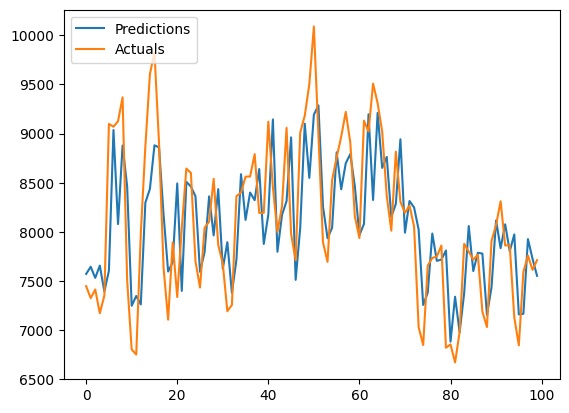

MAPE: 4.35%
RMSE: 463.33
MAE : 349.75


Predictions      Actuals
0    7571.149414  7446.897083
1    7643.940430  7324.388958
2    7531.260742  7412.811667
3    7655.700684  7171.183125
4    7392.431152  7350.264167
..           ...          ...
721  7334.918945  7374.332292
722  7746.181641  8039.583333
723  8045.002930  8575.767292
724  8325.034180  7909.507917
725  7416.711426  7144.386250

[726 rows x 2 columns]

In [ ]:
model8 = load_model('model8.keras')

predictions_plot(model8, X_train8, y_train8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


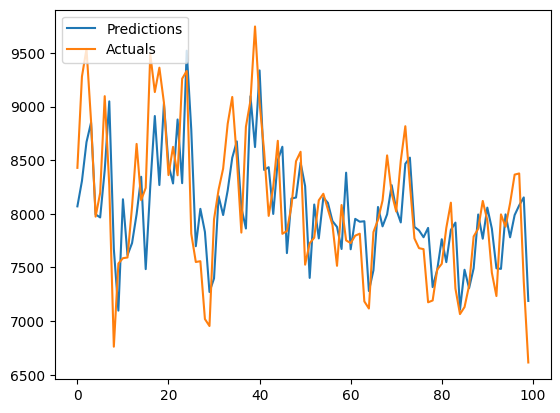

MAPE: 4.03%
RMSE: 407.17
MAE : 320.71


Predictions      Actuals
0    8069.549805  8428.290208
1    8306.454102  9279.195417
2    8668.508789  9537.097917
3    8850.196289  8863.333125
4    7994.516602  7973.787500
..           ...          ...
355  7667.656250  8447.030417
356  8220.350586  8771.408958
357  8196.762695  8487.014792
358  7971.295898  8380.489792
359  8097.591797  8437.980833

[360 rows x 2 columns]

In [ ]:
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


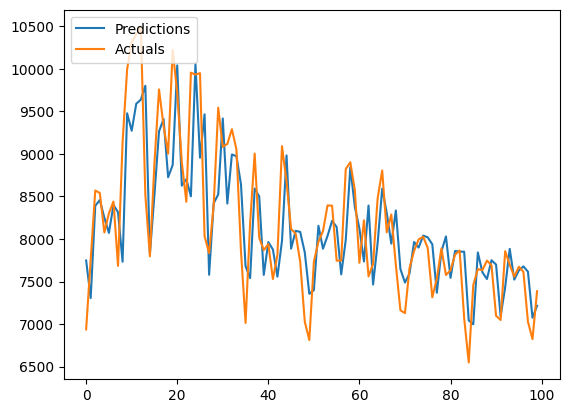

MAPE: 4.25%
RMSE: 438.59
MAE : 335.87


Predictions      Actuals
0    7747.236816  6937.700208
1    7305.927246  7759.521667
2    8390.083984  8569.568125
3    8458.120117  8540.904167
4    8249.711914  8076.513125
..           ...          ...
355  7579.313965  7508.199792
356  7737.856445  7694.271458
357  7739.881348  7746.240833
358  7747.832031  8321.401042
359  8253.144531  8503.726875

[360 rows x 2 columns]

In [ ]:
predictions_plot(model8, X_test8, y_test8, 0, 100)

## Model 9 - Increase Window Size to 14 ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

i = X_train9.shape[1]
j = X_train9.shape[2]

In [ ]:
model9 = Sequential()
model9.add(InputLayer((i, j)))
model9.add(LSTM(64))
model9.add(Dense(8, 'tanh'))
model9.add(Dense(1, 'linear'))

model9.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0751 - root_mean_squared_error: 0.2691 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1385
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


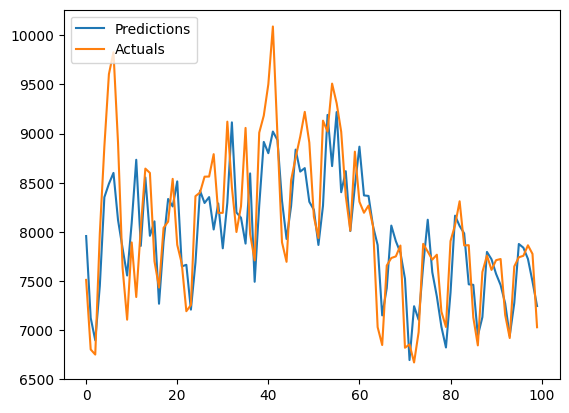

MAPE: 3.68%
RMSE: 404.40
MAE : 299.15


Predictions      Actuals
0    7956.814453  7510.325833
1    7123.597168  6801.918750
2    6894.992188  6750.140625
3    7448.041992  7981.096667
4    8352.144531  8868.038333
..           ...          ...
712  7493.741211  7374.332292
713  7757.053223  8039.583333
714  8038.034668  8575.767292
715  8145.959961  7909.507917
716  7388.490234  7144.386250

[717 rows x 2 columns]

In [ ]:
model9 = load_model('model9.keras')

predictions_plot(model9, X_train9, y_train9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


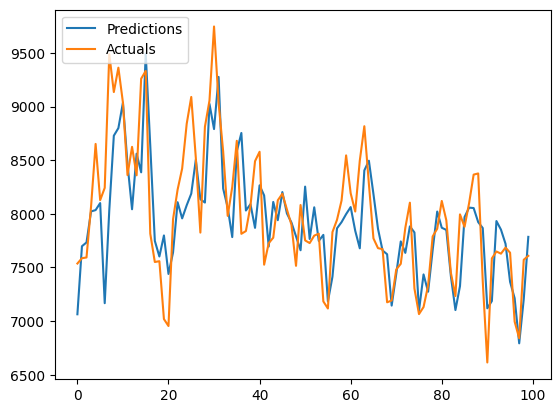

MAPE: 3.41%
RMSE: 359.46
MAE : 273.15


Predictions      Actuals
0    7063.778320  7536.762292
1    7697.904297  7586.311250
2    7733.251953  7593.115208
3    8022.175781  8067.645208
4    8034.689941  8651.321042
..           ...          ...
346  7706.729004  8447.030417
347  8000.041016  8771.408958
348  8092.461426  8487.014792
349  7764.846680  8380.489792
350  7901.439941  8437.980833

[351 rows x 2 columns]

In [ ]:
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


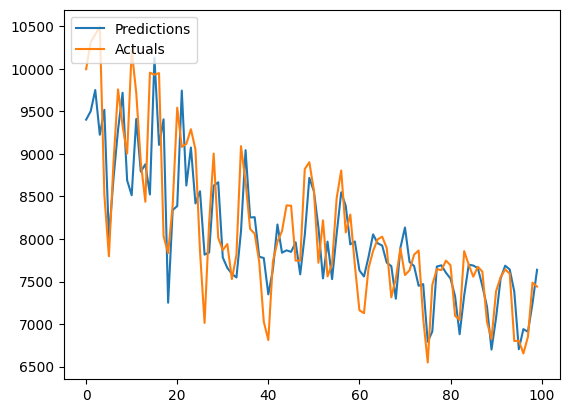

MAPE: 3.82%
RMSE: 404.46
MAE : 305.90


Predictions       Actuals
0    9402.772461   9995.508542
1    9501.887695  10313.686458
2    9750.536133  10402.964375
3    9225.166016  10497.618958
4    9518.205078   8517.349375
..           ...           ...
346  7397.762695   7508.199792
347  7484.368164   7694.271458
348  7661.873047   7746.240833
349  7625.888184   8321.401042
350  8119.351562   8503.726875

[351 rows x 2 columns]

In [ ]:
predictions_plot(model9, X_test9, y_test9, 0, 100)

## Model 10 - Add CDD/HDD ##

In [ ]:
tempDemandDF5 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

i = X_train10.shape[1]
j = X_train10.shape[2]

In [ ]:
model10 = Sequential()
model10.add(InputLayer((i, j)))
model10.add(LSTM(64))
model10.add(Dense(8, 'tanh'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0263 - root_mean_squared_error: 0.1611 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


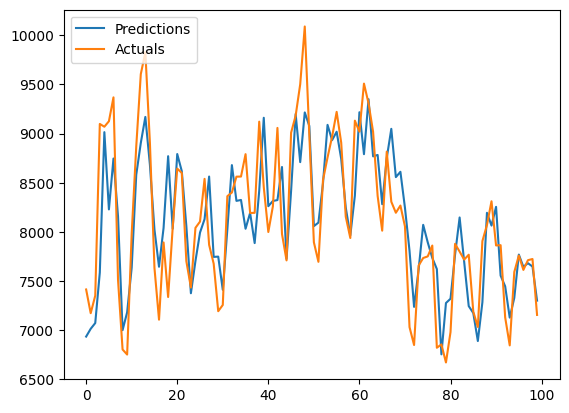

MAPE: 3.61%
RMSE: 397.02
MAE : 290.29


Predictions      Actuals
0    6933.213867  7412.811667
1    7012.350586  7171.183125
2    7071.078125  7350.264167
3    7585.543457  9098.258333
4    9014.796875  9070.002917
..           ...          ...
719  7891.549316  7374.332292
720  8108.322754  8039.583333
721  8183.513184  8575.767292
722  8168.178711  7909.507917
723  7235.670898  7144.386250

[724 rows x 2 columns]

In [ ]:
model10 = load_model('model10.keras')
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


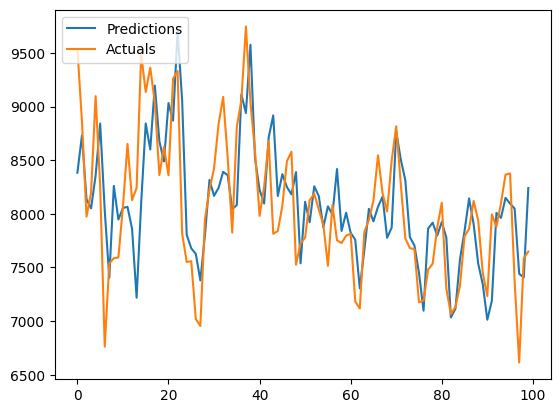

MAPE: 3.63%
RMSE: 376.91
MAE : 287.91


Predictions      Actuals
0    8382.961914  9537.097917
1    8729.414062  8863.333125
2    8136.274902  7973.787500
3    8050.490723  8194.981667
4    8356.273438  9096.434375
..           ...          ...
353  7955.618164  8447.030417
354  8237.077148  8771.408958
355  8262.768555  8487.014792
356  7798.436035  8380.489792
357  7806.755371  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


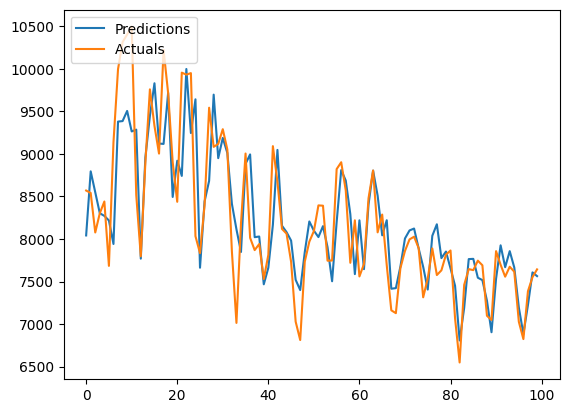

MAPE: 3.92%
RMSE: 411.51
MAE : 310.42


Predictions      Actuals
0    8041.860840  8569.568125
1    8794.991211  8540.904167
2    8548.887695  8076.513125
3    8302.727539  8302.971875
4    8271.584961  8440.820000
..           ...          ...
353  7857.707031  7508.199792
354  7825.393555  7694.271458
355  7894.996582  7746.240833
356  7750.884277  8321.401042
357  7840.971191  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model10, X_test10, y_test10, 0, 100)

## Model 11 - Remove Avg Temp from Model 10 ##

In [ ]:
tempDemandDF6 = test_df[['avg_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

i = X_train11.shape[1]
j = X_train11.shape[2]

In [ ]:
model11 = Sequential()
model11.add(InputLayer((i, j)))
model11.add(LSTM(64))
model11.add(Dense(8, 'tanh'))
model11.add(Dense(1, 'linear'))

model11.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1278 - root_mean_squared_error: 0.3448 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


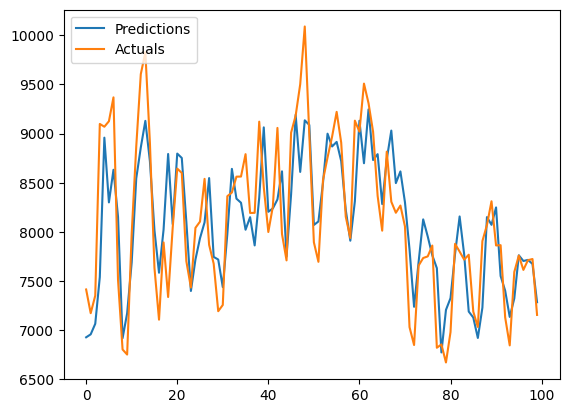

MAPE: 3.59%
RMSE: 395.80
MAE : 288.77


Predictions      Actuals
0    6925.831055  7412.811667
1    6956.041992  7171.183125
2    7063.410645  7350.264167
3    7539.697754  9098.258333
4    8958.626953  9070.002917
..           ...          ...
719  8002.269531  7374.332292
720  8188.039062  8039.583333
721  8223.855469  8575.767292
722  8203.455078  7909.507917
723  7435.191406  7144.386250

[724 rows x 2 columns]

In [ ]:
model11 = load_model('model11.keras')

predictions_plot(model11, X_train11, y_train11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


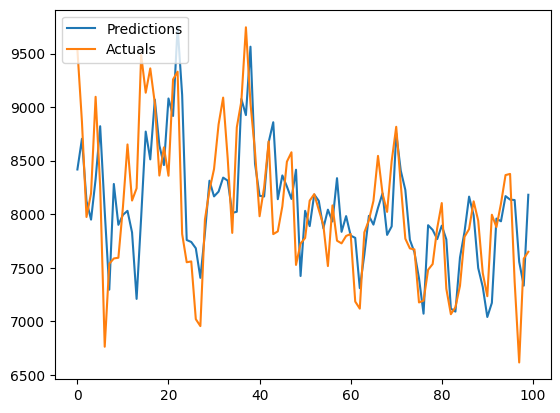

MAPE: 3.65%
RMSE: 381.69
MAE : 290.09


Predictions      Actuals
0    8417.506836  9537.097917
1    8704.324219  8863.333125
2    8123.105957  7973.787500
3    7948.884277  8194.981667
4    8326.700195  9096.434375
..           ...          ...
353  7970.770020  8447.030417
354  8225.155273  8771.408958
355  8247.978516  8487.014792
356  7797.210938  8380.489792
357  7713.233398  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


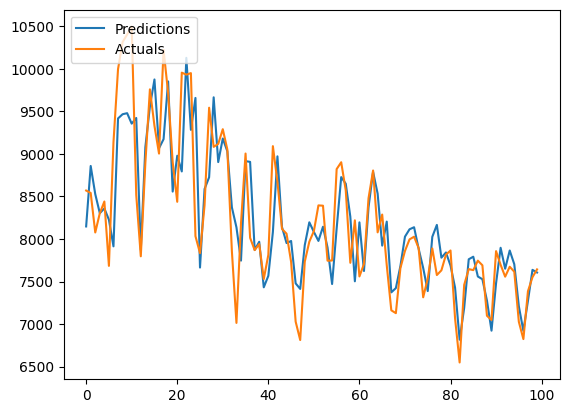

MAPE: 3.97%
RMSE: 416.17
MAE : 314.53


Predictions      Actuals
0    8147.584473  8569.568125
1    8858.274414  8540.904167
2    8527.699219  8076.513125
3    8303.992188  8302.971875
4    8358.952148  8440.820000
..           ...          ...
353  7905.213867  7508.199792
354  7937.954102  7694.271458
355  7864.230469  7746.240833
356  7740.929199  8321.401042
357  7701.964844  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model11, X_test11, y_test11, 0, 100)

## Introduce Other Weather Features ##

## Model 12 - Precipitation ##

In [ ]:
tempPrecipDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempPrecipDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

i = X_train12.shape[1]
j = X_train12.shape[2]

In [ ]:
model12 = Sequential()
model12.add(InputLayer((i, j)))
model12.add(LSTM(64))
model12.add(Dense(8, 'tanh'))
model12.add(Dense(1, 'linear'))

model12.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0951 - root_mean_squared_error: 0.3001 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1237
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1294 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


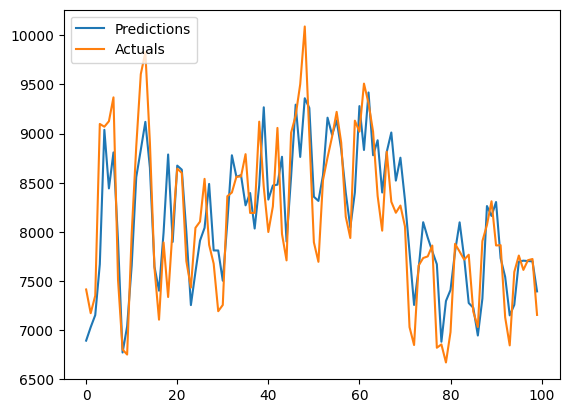

MAPE: 3.45%
RMSE: 375.21
MAE : 276.84


Predictions      Actuals
0    6891.878418  7412.811667
1    7028.700684  7171.183125
2    7151.935059  7350.264167
3    7670.131348  9098.258333
4    9038.543945  9070.002917
..           ...          ...
719  7981.328125  7374.332292
720  8230.519531  8039.583333
721  8305.499023  8575.767292
722  8045.065430  7909.507917
723  7363.026367  7144.386250

[724 rows x 2 columns]

In [ ]:
model12 = load_model('model12.keras')

predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


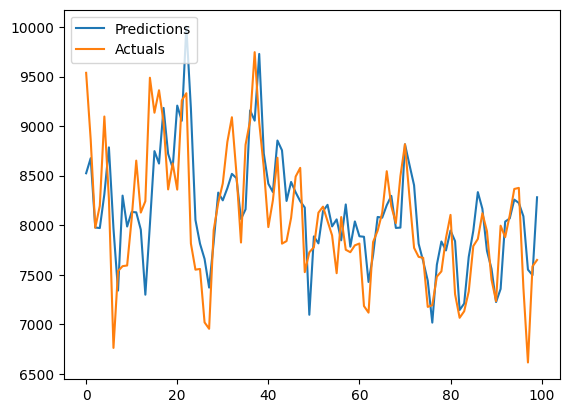

MAPE: 3.54%
RMSE: 371.22
MAE : 280.46


Predictions      Actuals
0    8523.890625  9537.097917
1    8676.078125  8863.333125
2    7976.455566  7973.787500
3    7970.950684  8194.981667
4    8313.106445  9096.434375
..           ...          ...
353  8105.283203  8447.030417
354  8401.750000  8771.408958
355  8430.569336  8487.014792
356  7990.823242  8380.489792
357  7894.449707  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


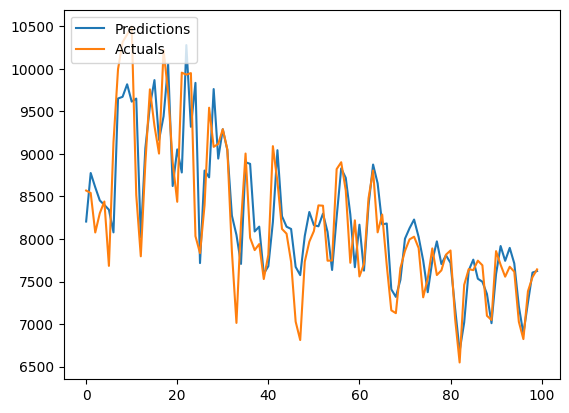

MAPE: 3.97%
RMSE: 409.16
MAE : 313.43


Predictions      Actuals
0    8205.329102  8569.568125
1    8775.465820  8540.904167
2    8607.699219  8076.513125
3    8453.135742  8302.971875
4    8400.291992  8440.820000
..           ...          ...
353  8077.794922  7508.199792
354  8129.008789  7694.271458
355  8096.145020  7746.240833
356  7977.992676  8321.401042
357  8023.094238  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model12, X_test12, y_test12, 0, 100)

## Model 13 - Sunlight ##

In [ ]:
tempSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

i = X_train13.shape[1]
j = X_train13.shape[2]

In [ ]:
model13 = Sequential()
model13.add(InputLayer((i, j)))
model13.add(LSTM(64))
model13.add(Dense(8, 'tanh'))
model13.add(Dense(1, 'linear'))

model13.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1013 - root_mean_squared_error: 0.3080 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


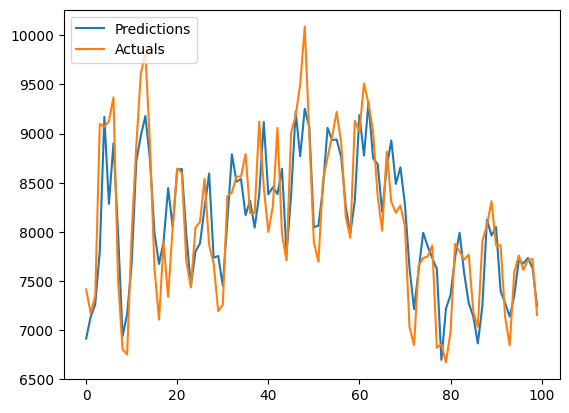

MAPE: 3.59%
RMSE: 387.36
MAE : 287.07


Predictions      Actuals
0    6912.112305  7412.811667
1    7134.627441  7171.183125
2    7260.549316  7350.264167
3    7805.362305  9098.258333
4    9170.269531  9070.002917
..           ...          ...
719  7718.053223  7374.332292
720  8152.044434  8039.583333
721  8110.845215  8575.767292
722  8026.388184  7909.507917
723  7267.303711  7144.386250

[724 rows x 2 columns]

In [ ]:
model13 = load_model('model13.keras')
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


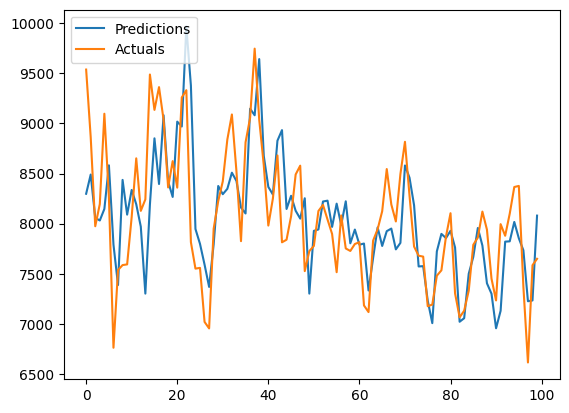

MAPE: 3.77%
RMSE: 391.34
MAE : 299.27


Predictions      Actuals
0    8297.913086  9537.097917
1    8489.339844  8863.333125
2    8057.194336  7973.787500
3    8031.231934  8194.981667
4    8146.550781  9096.434375
..           ...          ...
353  8203.908203  8447.030417
354  8527.072266  8771.408958
355  8522.515625  8487.014792
356  8095.277832  8380.489792
357  8021.682617  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


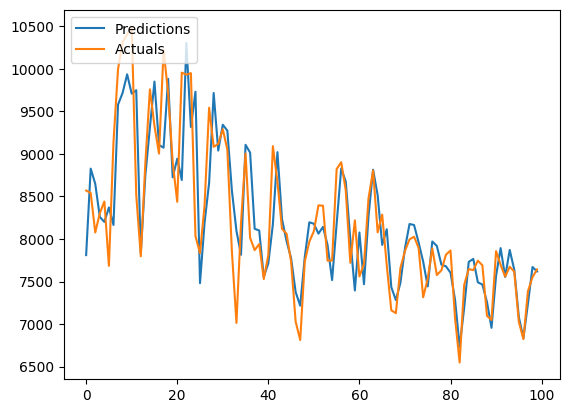

MAPE: 3.95%
RMSE: 412.29
MAE : 312.10


Predictions      Actuals
0    7810.778809  8569.568125
1    8827.215820  8540.904167
2    8648.592773  8076.513125
3    8259.433594  8302.971875
4    8200.412109  8440.820000
..           ...          ...
353  7901.370117  7508.199792
354  8001.198730  7694.271458
355  8118.615234  7746.240833
356  7907.590332  8321.401042
357  7967.013184  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model13, X_test13, y_test13, 0, 100)

## Model 14 - Precipitation and Sunlight ##

In [ ]:
tempPreSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight', 'temp_range']].copy()


In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(tempPreSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

i = X_train14.shape[1]
j = X_train14.shape[2]

In [ ]:
model14 = Sequential()
model14.add(InputLayer((i, j)))
model14.add(LSTM(64))
model14.add(Dense(8, 'tanh'))
model14.add(Dense(1, 'linear'))

model14.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0487 - root_mean_squared_error: 0.2177 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1238
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


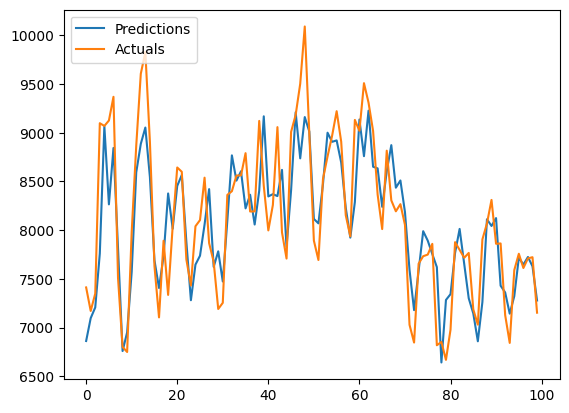

MAPE: 3.50%
RMSE: 383.12
MAE : 281.41


Predictions      Actuals
0    6863.172852  7412.811667
1    7097.534180  7171.183125
2    7207.706055  7350.264167
3    7761.262695  9098.258333
4    9066.957031  9070.002917
..           ...          ...
719  7763.056641  7374.332292
720  8246.534180  8039.583333
721  8191.451660  8575.767292
722  7954.228027  7909.507917
723  7326.362793  7144.386250

[724 rows x 2 columns]

In [ ]:
model14 = load_model('model14.keras')

predictions_plot(model14, X_train14, y_train14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


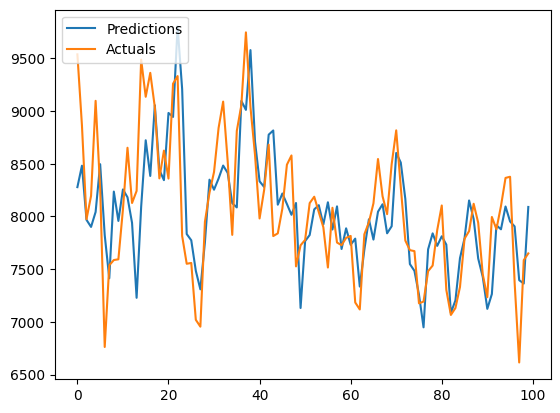

MAPE: 3.58%
RMSE: 373.82
MAE : 284.35


Predictions      Actuals
0    8277.786133  9537.097917
1    8481.076172  8863.333125
2    7967.399414  7973.787500
3    7900.437500  8194.981667
4    8042.351074  9096.434375
..           ...          ...
353  8227.698242  8447.030417
354  8505.805664  8771.408958
355  8396.472656  8487.014792
356  7909.272949  8380.489792
357  7856.721191  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


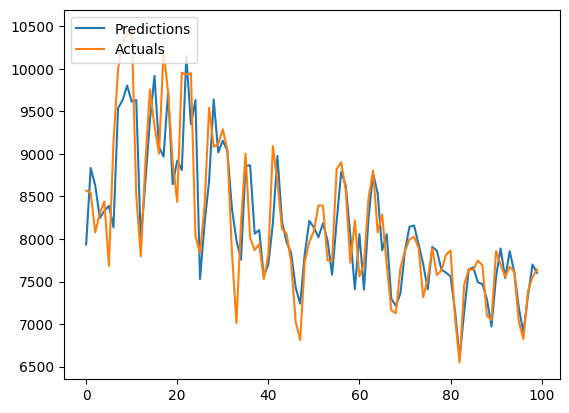

MAPE: 3.91%
RMSE: 405.52
MAE : 308.42


Predictions      Actuals
0    7934.631836  8569.568125
1    8834.369141  8540.904167
2    8628.586914  8076.513125
3    8246.840820  8302.971875
4    8329.779297  8440.820000
..           ...          ...
353  8086.260742  7508.199792
354  8126.979980  7694.271458
355  8174.828613  7746.240833
356  7965.973633  8321.401042
357  7902.171875  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model14, X_test14, y_test14, 0, 100)

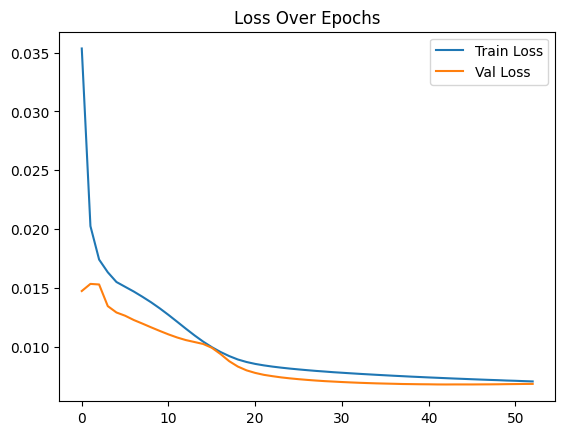

In [ ]:
plt.plot(history14.history['loss'], label='Train Loss')
plt.plot(history14.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasonality ##

## Seasons ##

In [ ]:
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

i = X_train15.shape[1]
j = X_train15.shape[2]

In [ ]:
model15 = Sequential()
model15.add(InputLayer((i, j)))
model15.add(LSTM(64))
model15.add(Dense(8, 'tanh'))
model15.add(Dense(1, 'linear'))

model15.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2117 - root_mean_squared_error: 0.4423 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1478
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


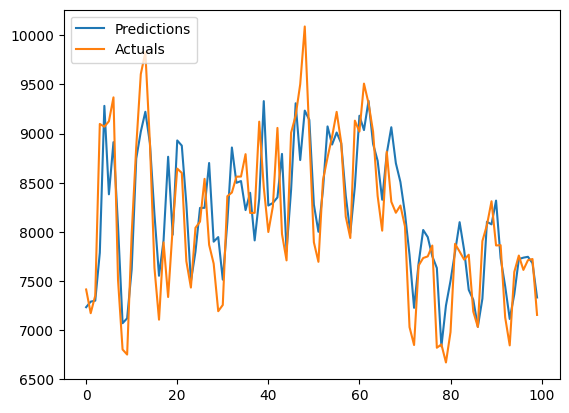

MAPE: 3.46%
RMSE: 380.76
MAE : 277.49


Predictions      Actuals
0    7232.392578  7412.811667
1    7288.984375  7171.183125
2    7298.740723  7350.264167
3    7786.908691  9098.258333
4    9282.426758  9070.002917
..           ...          ...
719  7966.630859  7374.332292
720  8328.713867  8039.583333
721  8324.588867  8575.767292
722  8180.837402  7909.507917
723  7284.442871  7144.386250

[724 rows x 2 columns]

In [ ]:
model15 = load_model('model15.keras')

predictions_plot(model15, X_train15, y_train15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


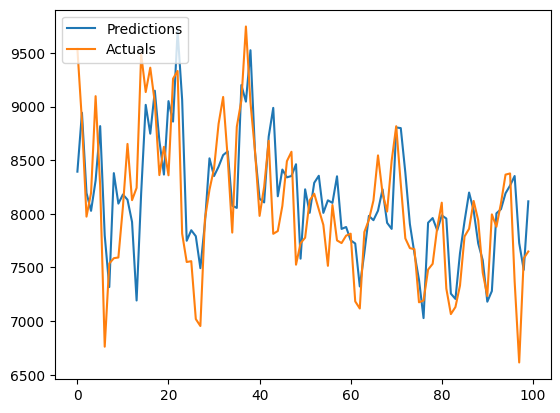

MAPE: 3.55%
RMSE: 376.04
MAE : 281.19


Predictions      Actuals
0    8392.883789  9537.097917
1    8941.912109  8863.333125
2    8194.175781  7973.787500
3    8027.513672  8194.981667
4    8310.282227  9096.434375
..           ...          ...
353  8185.299316  8447.030417
354  8491.354492  8771.408958
355  8327.439453  8487.014792
356  7778.098633  8380.489792
357  7660.037109  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


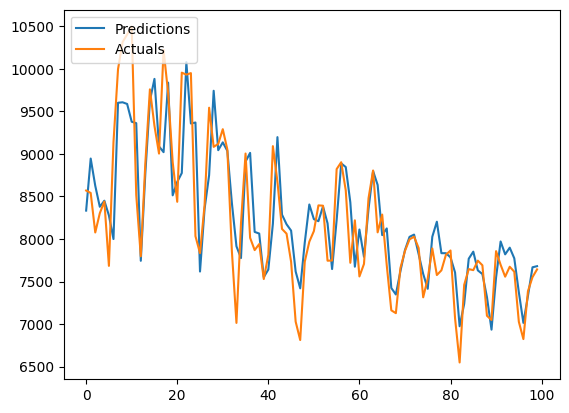

MAPE: 3.74%
RMSE: 394.37
MAE : 295.62


Predictions      Actuals
0    8333.733398  8569.568125
1    8945.471680  8540.904167
2    8625.666992  8076.513125
3    8378.694336  8302.971875
4    8449.988281  8440.820000
..           ...          ...
353  8042.061035  7508.199792
354  8084.688477  7694.271458
355  8061.844238  7746.240833
356  7926.251953  8321.401042
357  7919.238281  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model15, X_test15, y_test15, 0, 100)

## Weekday/Weekend ##

In [ ]:
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

i = X_train16.shape[1]
j = X_train16.shape[2]

In [ ]:
model16 = Sequential()
model16.add(InputLayer((7, 9)))
model16.add(LSTM(64))
model16.add(Dense(8, 'tanh'))
model16.add(Dense(1, 'linear'))

model16.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1146 - root_mean_squared_error: 0.3284 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - root_mean_squared_error: 0.1185 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1027
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


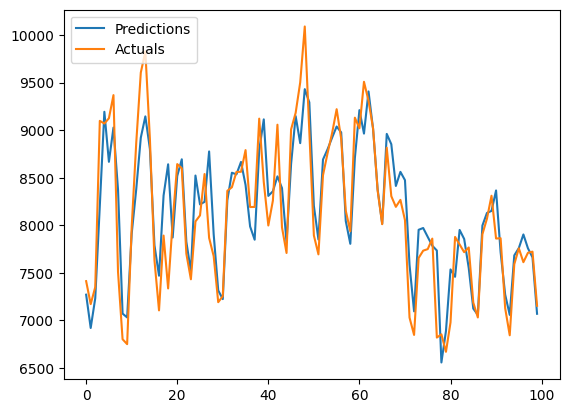

MAPE: 2.89%
RMSE: 330.79
MAE : 231.68


Predictions      Actuals
0    7270.386230  7412.811667
1    6920.250488  7171.183125
2    7232.757812  7350.264167
3    8204.346680  9098.258333
4    9193.708984  9070.002917
..           ...          ...
719  7415.308594  7374.332292
720  7874.427246  8039.583333
721  8109.201660  8575.767292
722  7808.831055  7909.507917
723  7367.020996  7144.386250

[724 rows x 2 columns]

In [ ]:
model16 = load_model('model16.keras')

predictions_plot(model16, X_train16, y_train16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


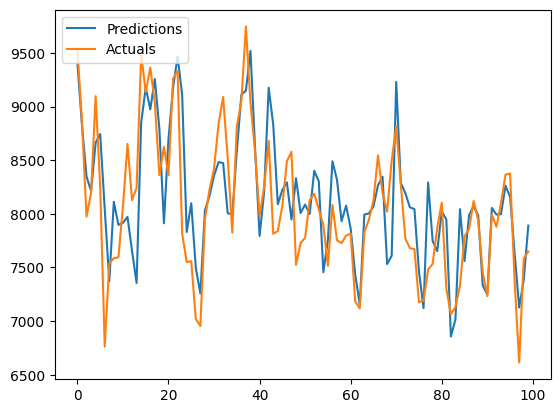

MAPE: 3.07%
RMSE: 333.41
MAE : 242.41


Predictions      Actuals
0    9406.012695  9537.097917
1    8828.307617  8863.333125
2    8349.022461  7973.787500
3    8213.056641  8194.981667
4    8662.458008  9096.434375
..           ...          ...
353  7667.174805  8447.030417
354  8075.320801  8771.408958
355  7698.454590  8487.014792
356  7646.624023  8380.489792
357  8577.290039  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


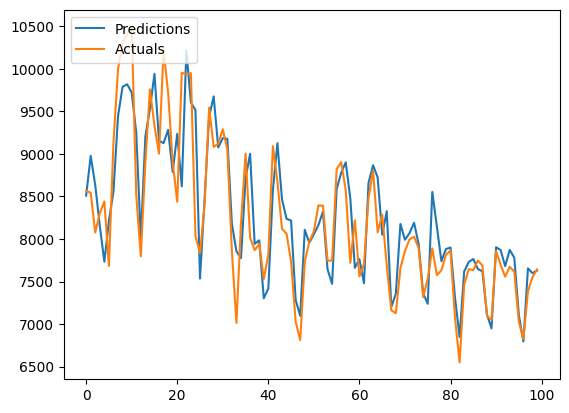

MAPE: 3.28%
RMSE: 356.59
MAE : 259.92


Predictions      Actuals
0    8509.573242  8569.568125
1    8976.235352  8540.904167
2    8632.764648  8076.513125
3    8152.630371  8302.971875
4    7732.978516  8440.820000
..           ...          ...
353  7392.693359  7508.199792
354  7089.581055  7694.271458
355  7578.441895  7746.240833
356  8450.882812  8321.401042
357  8383.872070  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model16, X_test16, y_test16, 0, 100)

## Day Of Week ##

In [ ]:
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

i = X_train17.shape[1]
j = X_train17.shape[2]

In [ ]:
model17 = Sequential()
model17.add(InputLayer((i, j)))
model17.add(LSTM(64))
model17.add(Dense(8, 'tanh'))
model17.add(Dense(1, 'linear'))

model17.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history17 = model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0635 - root_mean_squared_error: 0.2462 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


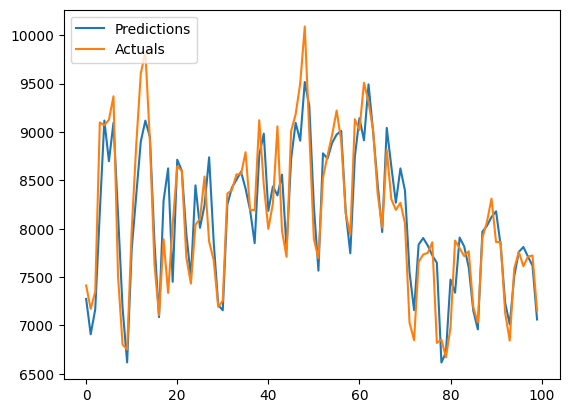

MAPE: 2.55%
RMSE: 295.02
MAE : 204.76


Predictions      Actuals
0    7273.637207  7412.811667
1    6908.461426  7171.183125
2    7166.881348  7350.264167
3    8169.823242  9098.258333
4    9117.984375  9070.002917
..           ...          ...
719  7027.730469  7374.332292
720  7930.278809  8039.583333
721  7875.213867  8575.767292
722  7813.711914  7909.507917
723  7252.052734  7144.386250

[724 rows x 2 columns]

In [ ]:
model17 = load_model('model17.keras')

predictions_plot(model17, X_train17, y_train17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


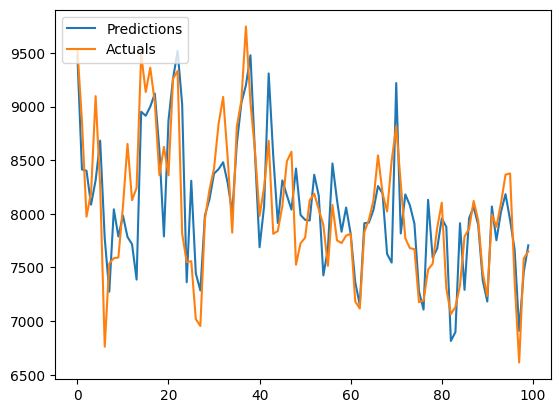

MAPE: 2.89%
RMSE: 318.48
MAE : 229.25


Predictions      Actuals
0    9472.168945  9537.097917
1    8413.274414  8863.333125
2    8401.107422  7973.787500
3    8085.940430  8194.981667
4    8311.278320  9096.434375
..           ...          ...
353  7575.391602  8447.030417
354  8010.796387  8771.408958
355  7854.454590  8487.014792
356  7576.053711  8380.489792
357  8615.956055  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model17, X_val17, y_val17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


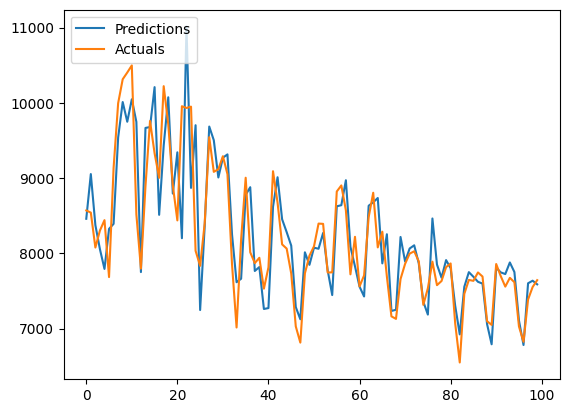

MAPE: 3.22%
RMSE: 357.32
MAE : 257.32


Predictions      Actuals
0    8458.904297  8569.568125
1    9053.325195  8540.904167
2    8374.274414  8076.513125
3    8054.597656  8302.971875
4    7792.038574  8440.820000
..           ...          ...
353  7184.526855  7508.199792
354  7033.002441  7694.271458
355  7483.345703  7746.240833
356  8519.889648  8321.401042
357  8055.499512  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model17, X_test17, y_test17, 0, 100)

## Month ##

In [ ]:
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

i = X_train18.shape[1]
j = X_train18.shape[2]

In [ ]:
model18 = Sequential()
model18.add(InputLayer((i, j)))
model18.add(LSTM(64))
model18.add(Dense(8, 'tanh'))
model18.add(Dense(1, 'linear'))

model18.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,033 (86.07 KB)

 Trainable params: 22,033 (86.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history18 = model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1175 - root_mean_squared_error: 0.3319 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1250 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154 - root_mean_squared_error: 0.1238 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


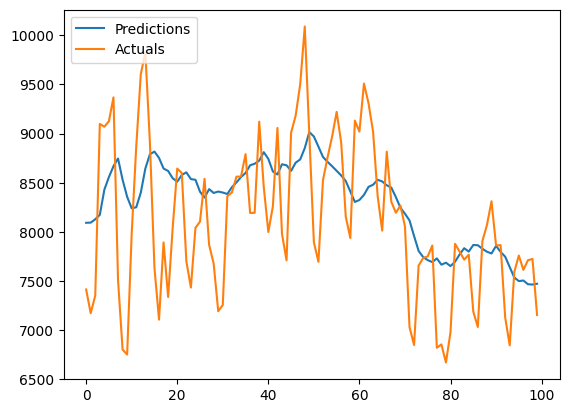

MAPE: 5.49%
RMSE: 567.24
MAE : 431.47


Predictions      Actuals
0    8091.888672  7412.811667
1    8093.570801  7171.183125
2    8127.461914  7350.264167
3    8172.812988  9098.258333
4    8429.250000  9070.002917
..           ...          ...
719  7967.021973  7374.332292
720  7948.627441  8039.583333
721  8009.191406  8575.767292
722  8129.494141  7909.507917
723  8175.440430  7144.386250

[724 rows x 2 columns]

In [ ]:
model18 = load_model('model18.keras')

predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


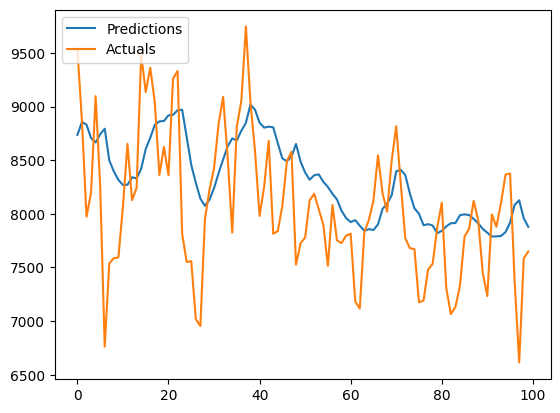

MAPE: 5.06%
RMSE: 502.17
MAE : 392.16


Predictions      Actuals
0    8734.954102  9537.097917
1    8855.000977  8863.333125
2    8831.175781  7973.787500
3    8706.099609  8194.981667
4    8664.914062  9096.434375
..           ...          ...
353  7836.763672  8447.030417
354  7924.610352  8771.408958
355  8100.142090  8487.014792
356  8217.711914  8380.489792
357  8295.138672  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model18, X_val18, y_val18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


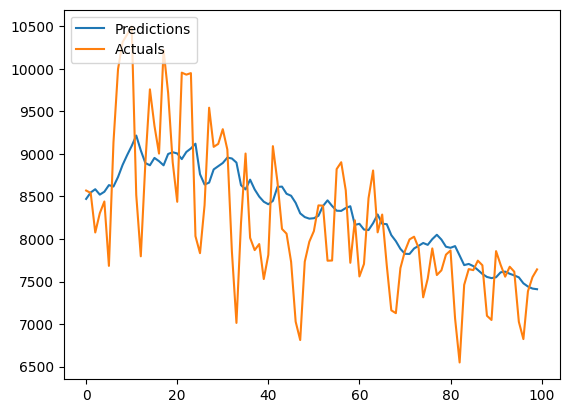

MAPE: 5.58%
RMSE: 563.99
MAE : 432.30


Predictions      Actuals
0    8470.986328  8569.568125
1    8546.545898  8540.904167
2    8584.933594  8076.513125
3    8521.415039  8302.971875
4    8555.278320  8440.820000
..           ...          ...
353  7964.748535  7508.199792
354  8012.309082  7694.271458
355  8065.184082  7746.240833
356  8106.254883  8321.401042
357  8170.186523  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model18, X_test18, y_test18, 0, 100)

## Seasons & Weekday/Weekend ##

In [30]:
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

i = X_train19.shape[1]
j = X_train19.shape[2]

In [ ]:
model19 = Sequential()
model19.add(InputLayer((i, j)))
model19.add(LSTM(64))
model19.add(Dense(8, 'tanh'))
model19.add(Dense(1, 'linear'))

model19.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history19 = model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0583 - root_mean_squared_error: 0.2344 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


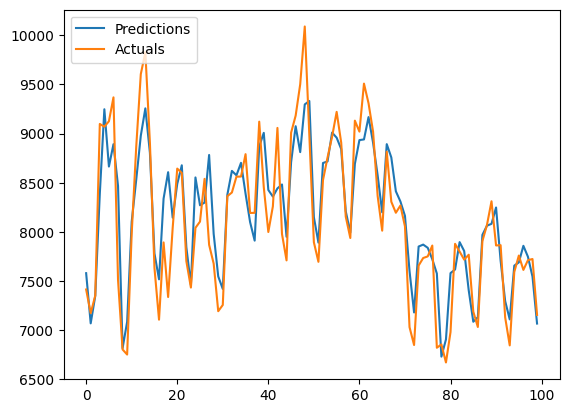

MAPE: 3.03%
RMSE: 348.25
MAE : 243.11


Predictions      Actuals
0    7578.685059  7412.811667
1    7067.876465  7171.183125
2    7346.801270  7350.264167
3    8387.425781  9098.258333
4    9247.960938  9070.002917
..           ...          ...
719  7668.494141  7374.332292
720  8097.353027  8039.583333
721  8109.571289  8575.767292
722  7936.541016  7909.507917
723  7483.729980  7144.386250

[724 rows x 2 columns]

In [ ]:
model19 = load_model('model19.keras')

predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


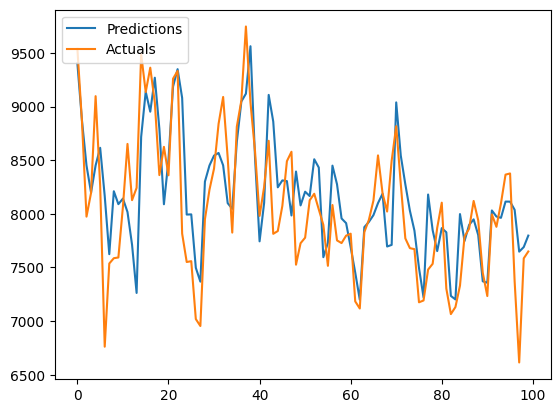

MAPE: 3.22%
RMSE: 346.95
MAE : 253.56


Predictions      Actuals
0    9400.623047  9537.097917
1    8872.063477  8863.333125
2    8450.384766  7973.787500
3    8197.560547  8194.981667
4    8451.233398  9096.434375
..           ...          ...
353  7933.935547  8447.030417
354  7999.262695  8771.408958
355  7864.356445  8487.014792
356  7624.084473  8380.489792
357  8593.639648  8437.980833

[358 rows x 2 columns]

In [ ]:
predictions_plot(model19, X_val19, y_val19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


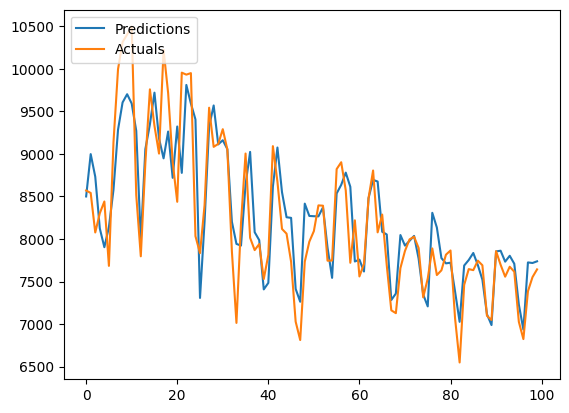

MAPE: 3.46%
RMSE: 374.89
MAE : 273.16


Predictions      Actuals
0    8500.052734  8569.568125
1    8997.500000  8540.904167
2    8732.459961  8076.513125
3    8124.269531  8302.971875
4    7903.560059  8440.820000
..           ...          ...
353  7629.129883  7508.199792
354  7218.886230  7694.271458
355  7445.859375  7746.240833
356  8345.013672  8321.401042
357  8410.269531  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model19, X_test19, y_test19, 0, 100)

## Switch to train/test only - compare Seasons & Seasons/Weekend ##

## Seasons & Weekday/Weekend - Train/Test ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

i = X_train20.shape[1]
j = X_train20.shape[2]

In [ ]:
model20 = Sequential()
model20.add(InputLayer((i, j)))
model20.add(LSTM(64))
model20.add(Dense(8, 'tanh'))
model20.add(Dense(1, 'linear'))

model20.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp20 = ModelCheckpoint('model20.keras', monitor='loss', save_best_only=True)
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history20 = model20.fit(X_train20, y_train20, epochs=100, callbacks=[cp20])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0415 - root_mean_squared_error: 0.1989
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


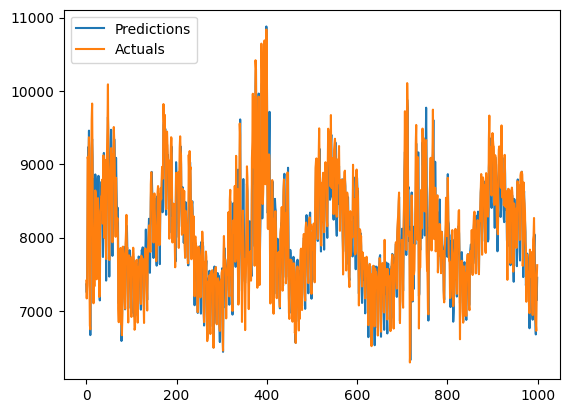

MAPE: 2.41%
RMSE: 274.00
MAE : 193.79


Predictions      Actuals
0     7363.658691  7412.811667
1     7252.873047  7171.183125
2     7371.234863  7350.264167
3     8167.104004  9098.258333
4     9231.645508  9070.002917
...           ...          ...
1084  8152.099121  8447.030417
1085  8929.057617  8771.408958
1086  8236.088867  8487.014792
1087  8044.711914  8380.489792
1088  8277.913086  8437.980833

[1089 rows x 2 columns]

In [ ]:
model20 = load_model('model20.keras')

predictions_plot(model20, X_train20, y_train20, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


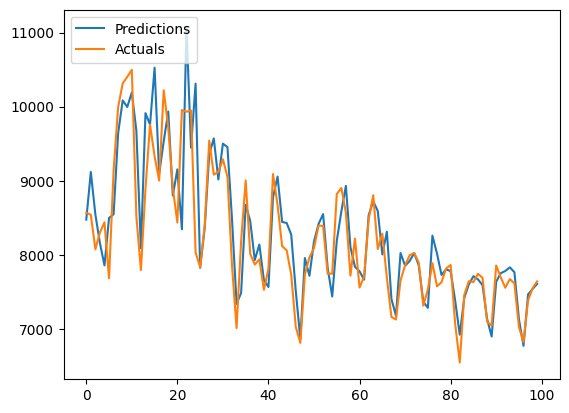

MAPE: 2.98%
RMSE: 350.94
MAE : 239.10


Predictions      Actuals
0    8476.519531  8569.568125
1    9118.553711  8540.904167
2    8545.598633  8076.513125
3    8158.280762  8302.971875
4    7858.676270  8440.820000
..           ...          ...
353  7563.729980  7508.199792
354  7717.290527  7694.271458
355  8142.241211  7746.240833
356  8462.486328  8321.401042
357  7943.433105  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model20, X_test20, y_test20, 0, 100)

## Seasons Only - Train/Test ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

i = X_train21.shape[1]
j = X_train21.shape[2]

In [ ]:
model21 = Sequential()
model21.add(InputLayer((i, j)))
model21.add(LSTM(64))
model21.add(Dense(8, 'tanh'))
model21.add(Dense(1, 'linear'))

model21.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp21 = ModelCheckpoint('model21.keras', monitor='loss', save_best_only=True)
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history21 = model21.fit(X_train21, y_train21, epochs=100, callbacks=[cp21])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0564 - root_mean_squared_error: 0.2304
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120 - root_mean_squared_error: 0.1093

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


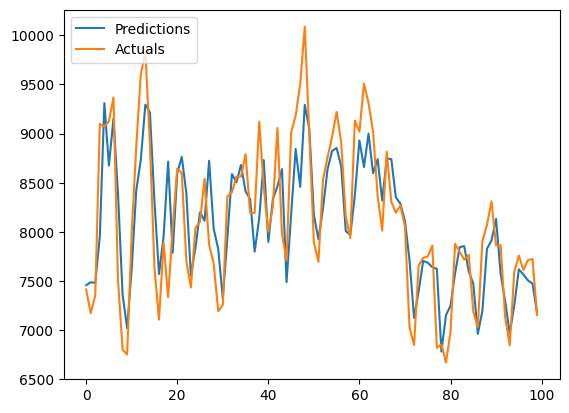

MAPE: 3.16%
RMSE: 346.44
MAE : 254.84


Predictions      Actuals
0     7456.198730  7412.811667
1     7486.223633  7171.183125
2     7480.406250  7350.264167
3     7951.744141  9098.258333
4     9310.744141  9070.002917
...           ...          ...
1084  8077.459961  8447.030417
1085  8609.857422  8771.408958
1086  8658.526367  8487.014792
1087  8096.583008  8380.489792
1088  8000.011719  8437.980833

[1089 rows x 2 columns]

In [ ]:
model21 = load_model('model21.keras')
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


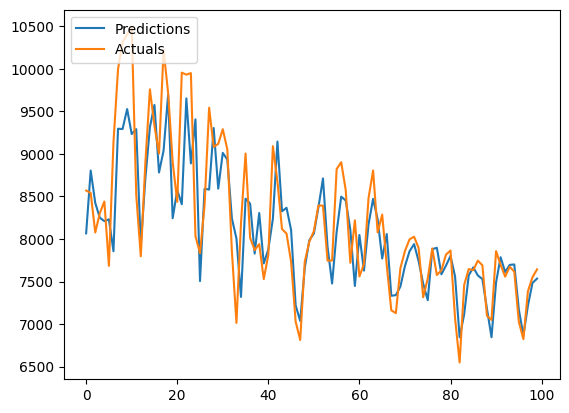

MAPE: 3.58%
RMSE: 393.34
MAE : 285.98


Predictions      Actuals
0    8066.540527  8569.568125
1    8804.816406  8540.904167
2    8423.918945  8076.513125
3    8249.818359  8302.971875
4    8210.251953  8440.820000
..           ...          ...
353  7887.329102  7508.199792
354  7990.826660  7694.271458
355  8002.822754  7746.240833
356  7827.420898  8321.401042
357  8115.286621  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model21, X_test21, y_test21, 0, 100)

## Weekend/Weekday Only - Train/Test ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data22 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

i = X_train22.shape[1]
j = X_train22.shape[2]

In [ ]:
model22 = Sequential()
model22.add(InputLayer((i, j)))
model22.add(LSTM(64))
model22.add(Dense(8, 'tanh'))
model22.add(Dense(1, 'linear'))

model22.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp22 = ModelCheckpoint('model22.keras', monitor='loss', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history22 = model22.fit(X_train22, y_train22, epochs=100, callbacks=[cp22])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0305 - root_mean_squared_error: 0.1726
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0987
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


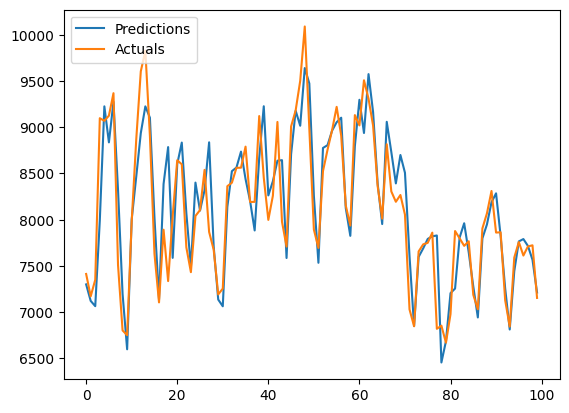

MAPE: 2.62%
RMSE: 293.17
MAE : 209.88


Predictions      Actuals
0     7299.943848  7412.811667
1     7121.286621  7171.183125
2     7064.392090  7350.264167
3     7993.116211  9098.258333
4     9226.529297  9070.002917
...           ...          ...
1084  7669.776367  8447.030417
1085  8392.142578  8771.408958
1086  7934.732422  8487.014792
1087  7855.445801  8380.489792
1088  8334.970703  8437.980833

[1089 rows x 2 columns]

In [ ]:
model22 = load_model('model22.keras')

predictions_plot(model22, X_train22, y_train22, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


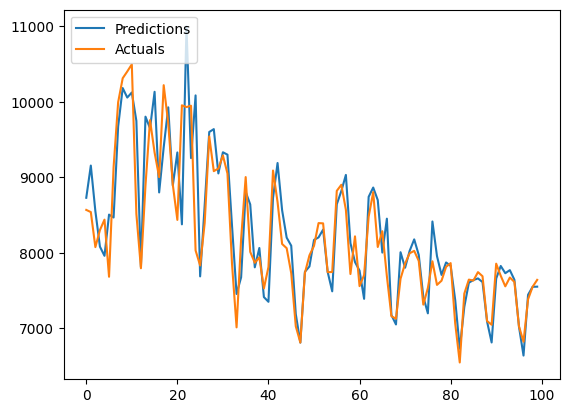

MAPE: 2.94%
RMSE: 339.21
MAE : 234.84


Predictions      Actuals
0    8730.294922  8569.568125
1    9156.963867  8540.904167
2    8552.143555  8076.513125
3    8082.989746  8302.971875
4    7961.556641  8440.820000
..           ...          ...
353  7379.399902  7508.199792
354  7413.585449  7694.271458
355  7767.799805  7746.240833
356  8444.127930  8321.401042
357  8144.435547  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model22, X_test22, y_test22, 0, 100)

## Optuna Trials ##

In [ ]:
'''study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study.optimize(objective, n_trials=100)'''

"study = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy.optimize(objective, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial = study.best_trial

print(f"  MAE: {trial.value:.2f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial = study.best_trial\n\nprint(f"  MAE: {trial.value:.2f}")\nprint("  Params:")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")'

In [ ]:
'''study2 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study2.optimize(objective2, n_trials=100)'''

"study2 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy2.optimize(objective2, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial2 = study2.best_trial

print(f"  MAE: {trial2.value:.2f}")
print("  Params:")
for key, value in trial2.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial2 = study2.best_trial\n\nprint(f"  MAE: {trial2.value:.2f}")\nprint("  Params:")\nfor key, value in trial2.params.items():\n    print(f"    {key}: {value}")'

## Model 20 Re-Run (Post Optuna) ##

In [31]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data23 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train23, y_train23 = data23['train']
X_test23, y_test23 = data23['test']

i = X_train23.shape[1]
j = X_train23.shape[2]

In [32]:
model23 = Sequential()
model23.add(InputLayer((i, j)))
model23.add(LSTM(32, dropout=0.013))
model23.add(Dense(8, 'tanh'))
model23.add(Dense(1, 'linear'))

model23.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
cp23 = ModelCheckpoint('model23.keras', monitor='loss', save_best_only=True)
model23.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history23 = model23.fit(X_train23, y_train23, epochs=100, batch_size=8, callbacks=[cp23])

Epoch 1/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: nan - root_mean_squared_error: nan
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: nan - root_mean_squared_error: nan
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: nan - root_mean_squared_error: nan
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: nan - root_mean_squared_error: nan
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: nan - root_mean_squared_error: nan
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: nan - root_mean_squared_error: nan
Epoch 7/100
184/410 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan - root_mean_squared_error: nan

KeyboardInterrupt: 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


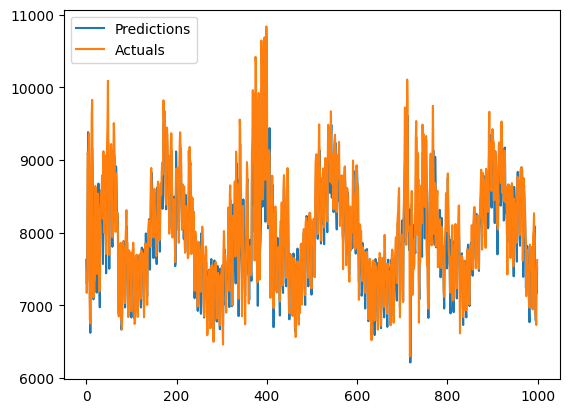

MAPE: 2.59%
RMSE: 299.57
MAE : 210.58


Predictions      Actuals
0     7627.324219  7412.811667
1     7294.479492  7171.183125
2     7356.245117  7350.264167
3     8390.517578  9098.258333
4     9384.411133  9070.002917
...           ...          ...
1084  8085.554688  8447.030417
1085  8762.534180  8771.408958
1086  8536.487305  8487.014792
1087  8051.107910  8380.489792
1088  8609.613281  8437.980833

[1089 rows x 2 columns]

In [ ]:
model23 = load_model('model23.keras')

predictions_plot(model23, X_train23, y_train23, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


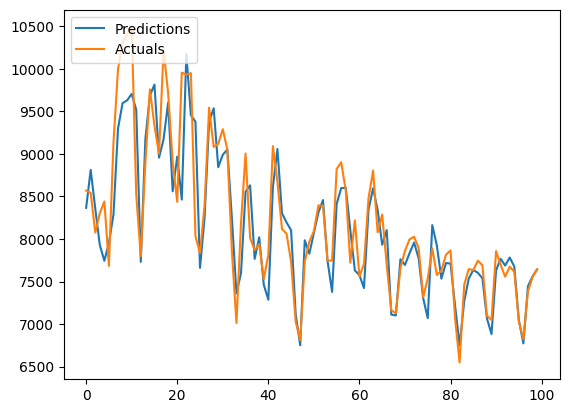

MAPE: 2.80%
RMSE: 323.71
MAE : 225.36


Predictions      Actuals
0    8366.470703  8569.568125
1    8812.555664  8540.904167
2    8358.119141  8076.513125
3    7929.522461  8302.971875
4    7743.688965  8440.820000
..           ...          ...
353  7624.356445  7508.199792
354  7590.157715  7694.271458
355  7989.113770  7746.240833
356  8704.978516  8321.401042
357  8538.896484  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model23, X_test23, y_test23, 0, 100)

## Model 20 Re-Run (Post Optuna Trial 2) ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data24 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train24, y_train24 = data24['train']
X_test24, y_test24 = data24['test']

i = X_train24.shape[1]
j = X_train24.shape[2]

In [ ]:
model24 = Sequential()
model24.add(InputLayer((i, j)))
model24.add(LSTM(57, dropout=0.013))
model24.add(Dense(8, 'tanh'))
model24.add(Dense(1, 'linear'))

model24.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 57)             │        16,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,661 (65.08 KB)

 Trainable params: 16,661 (65.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp24 = ModelCheckpoint('model24.keras', monitor='loss', save_best_only=True)
model24.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0012, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history24 = model24.fit(X_train24, y_train24, epochs=100, batch_size=32, callbacks=[cp24])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0238 - root_mean_squared_error: 0.1536
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - root_mean_squared_error: 0.1022
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - root_mean_squared_error: 0.1027
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0951
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


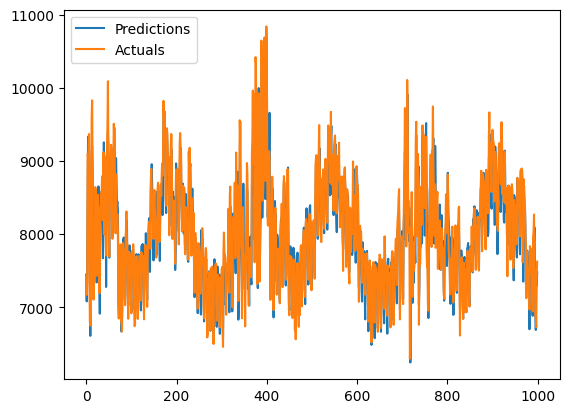

MAPE: 2.40%
RMSE: 272.01
MAE : 194.23


Predictions      Actuals
0     7448.837891  7412.811667
1     7081.592285  7171.183125
2     7494.125000  7350.264167
3     8403.644531  9098.258333
4     9331.171875  9070.002917
...           ...          ...
1084  7974.582031  8447.030417
1085  8749.527344  8771.408958
1086  8187.979980  8487.014792
1087  7968.758301  8380.489792
1088  7960.751465  8437.980833

[1089 rows x 2 columns]

In [ ]:
model24 = load_model('model24.keras')

predictions_plot(model24, X_train24, y_train24, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


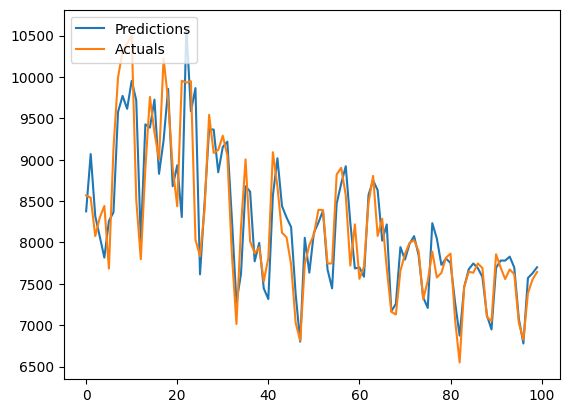

MAPE: 2.91%
RMSE: 336.36
MAE : 234.29


Predictions      Actuals
0    8375.923828  8569.568125
1    9068.547852  8540.904167
2    8317.995117  8076.513125
3    8068.558105  8302.971875
4    7816.497559  8440.820000
..           ...          ...
353  7526.911621  7508.199792
354  7441.784668  7694.271458
355  7860.582520  7746.240833
356  8268.477539  8321.401042
357  8053.354980  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model24, X_test24, y_test24, 0, 100)

## Model 20 Re-Run (Post Optuna) - Batch Size Adjust ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data25 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train25, y_train25 = data25['train']
X_test25, y_test25 = data25['test']

i = X_train25.shape[1]
j = X_train25.shape[2]

In [ ]:
model25 = Sequential()
model25.add(InputLayer((i, j)))
model25.add(LSTM(32, dropout=0.013))
model25.add(Dense(8, 'tanh'))
model25.add(Dense(1, 'linear'))

model25.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp25 = ModelCheckpoint('model25.keras', monitor='loss', save_best_only=True)
model25.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history25 = model25.fit(X_train25, y_train25, epochs=100, batch_size=4, callbacks=[cp25])

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0509 - root_mean_squared_error: 0.2098
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - root_mean_squared_error: 0.1180
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - root_mean_squared_error: 0.1064
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - root_mean_squared_error: 0.0997
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - root_mean_squared_error: 0.0947
Epoch 9/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954
Epoch 10/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


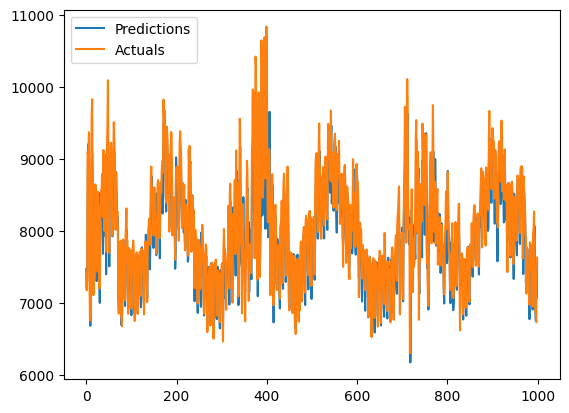

MAPE: 2.70%
RMSE: 306.64
MAE : 220.76


Predictions      Actuals
0     7469.645996  7412.811667
1     7211.493164  7171.183125
2     7296.711914  7350.264167
3     8320.713867  9098.258333
4     9202.193359  9070.002917
...           ...          ...
1084  7979.252930  8447.030417
1085  8635.653320  8771.408958
1086  8315.314453  8487.014792
1087  8035.945312  8380.489792
1088  8617.413086  8437.980833

[1089 rows x 2 columns]

In [ ]:
model25 = load_model('model25.keras')

predictions_plot(model25, X_train25, y_train25, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


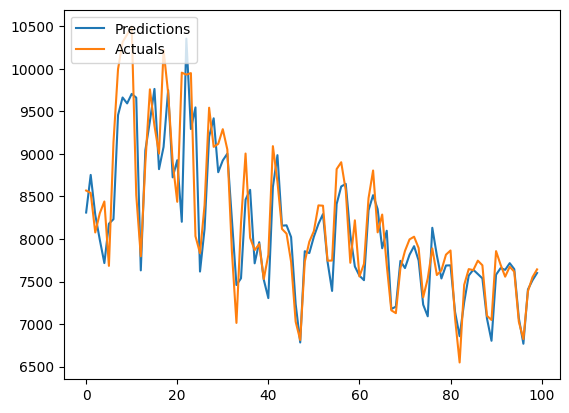

MAPE: 2.90%
RMSE: 337.49
MAE : 234.65


Predictions      Actuals
0    8311.040039  8569.568125
1    8753.171875  8540.904167
2    8285.132812  8076.513125
3    7990.513184  8302.971875
4    7717.231445  8440.820000
..           ...          ...
353  7548.660645  7508.199792
354  7507.583984  7694.271458
355  7936.303223  7746.240833
356  8608.991211  8321.401042
357  8269.744141  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model25, X_test25, y_test25, 0, 100)

## Stacked LSTM - From Model 23 ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data26 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train26, y_train26 = data26['train']
X_test26, y_test26 = data26['test']

i = X_train26.shape[1]
j = X_train26.shape[2]

In [ ]:
model26 = Sequential()
model26.add(InputLayer((i, j)))
model26.add(LSTM(32, dropout=0.013, return_sequences=True))
model26.add(LSTM(16, dropout=0.013))
model26.add(Dense(8, 'tanh'))
model26.add(Dense(1, 'linear'))

model26.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 7, 32)          │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,169 (35.82 KB)

 Trainable params: 9,169 (35.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp26 = ModelCheckpoint('model26.keras', monitor='loss', save_best_only=True)
model26.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history26 = model26.fit(X_train26, y_train26, epochs=100, batch_size=8, callbacks=[cp26])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0624 - root_mean_squared_error: 0.2391
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0160 - root_mean_squared_error: 0.1262
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0140 - root_mean_squared_error: 0.1180
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126 - root_mean_squared_error: 0.1119
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0116 - root_mean_squared_error: 0.1073
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113 - root_mean_squared_error: 0.1059
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


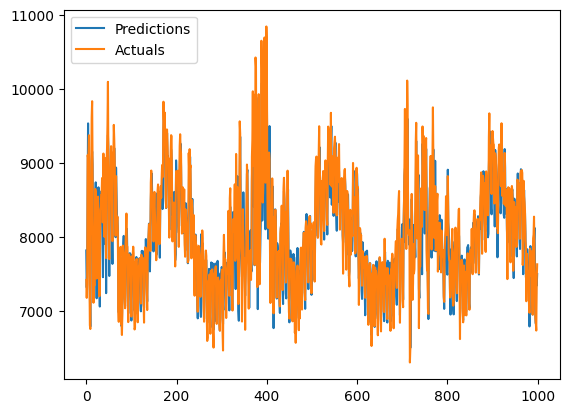

MAPE: 2.58%
RMSE: 294.75
MAE : 208.95


Predictions      Actuals
0     7811.693848  7412.811667
1     7310.812988  7171.183125
2     7525.857910  7350.264167
3     8531.825195  9098.258333
4     9529.260742  9070.002917
...           ...          ...
1084  8123.367676  8447.030417
1085  8855.436523  8771.408958
1086  8434.931641  8487.014792
1087  8119.921875  8380.489792
1088  8678.633789  8437.980833

[1089 rows x 2 columns]

In [ ]:
model26 = load_model('model26.keras')

predictions_plot(model26, X_train26, y_train26, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


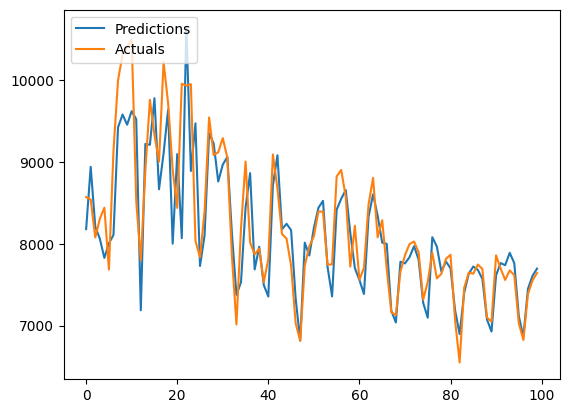

MAPE: 3.07%
RMSE: 354.31
MAE : 246.23


Predictions      Actuals
0    8178.670898  8569.568125
1    8939.752930  8540.904167
2    8209.717773  8076.513125
3    8061.905762  8302.971875
4    7826.633789  8440.820000
..           ...          ...
353  7714.581055  7508.199792
354  7735.949707  7694.271458
355  8357.392578  7746.240833
356  8767.832031  8321.401042
357  8557.643555  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model26, X_test26, y_test26, 0, 100)

## CNN-LSTM Test - From Model 23 ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data27 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train27, y_train27 = data27['train']
X_test27, y_test27 = data27['test']

i = X_train27.shape[1]
j = X_train27.shape[2]

In [ ]:
model27 = Sequential()
model27.add(InputLayer((i, j)))
model27.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model27.add(MaxPooling1D(pool_size=2))
model27.add(Dropout(0.013))
model27.add(LSTM(32, dropout=0.013))
model27.add(Dense(8, 'tanh'))
model27.add(Dense(1, 'linear'))

model27.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5, 64)          │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,249 (59.57 KB)

 Trainable params: 15,249 (59.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp27 = ModelCheckpoint('model27.keras', monitor='loss', save_best_only=True)
model27.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history27 = model27.fit(X_train27, y_train27, epochs=100, batch_size=8, callbacks=[cp27])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0462 - root_mean_squared_error: 0.2034
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1162
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0125 - root_mean_squared_error: 0.1114
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122 - root_mean_squared_error: 0.1101
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - root_mean_squared_error: 0.1088
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - root_mean_squared_error: 0.1074
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.1069
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - root_mean_squared_error: 0.1058
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - root_mean_squared_error: 0.1046
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


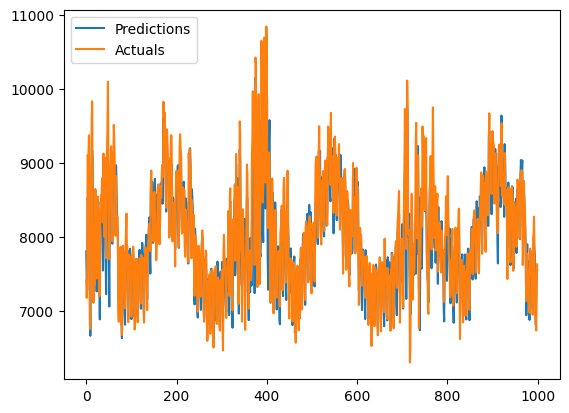

MAPE: 2.66%
RMSE: 295.92
MAE : 215.18


Predictions      Actuals
0     7799.773926  7412.811667
1     7427.324707  7171.183125
2     7274.088867  7350.264167
3     8521.522461  9098.258333
4     8476.186523  9070.002917
...           ...          ...
1084  8577.790039  8447.030417
1085  8632.708984  8771.408958
1086  8210.685547  8487.014792
1087  7973.059082  8380.489792
1088  8122.446289  8437.980833

[1089 rows x 2 columns]

In [ ]:
model27 = load_model('model27.keras')

predictions_plot(model27, X_train27, y_train27, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


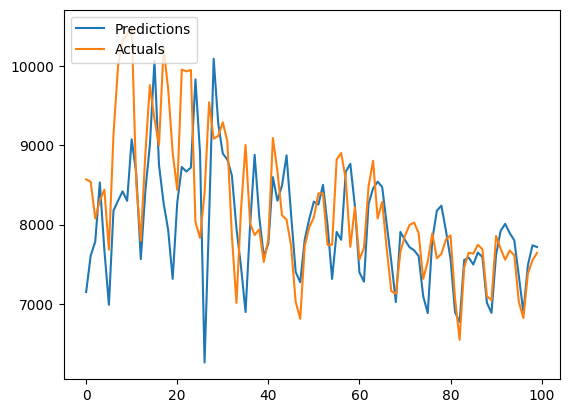

MAPE: 4.59%
RMSE: 540.06
MAE : 374.87


Predictions      Actuals
0    7151.386719  8569.568125
1    7610.308105  8540.904167
2    7786.144531  8076.513125
3    8531.581055  8302.971875
4    7680.768066  8440.820000
..           ...          ...
353  7963.555664  7508.199792
354  7549.503906  7694.271458
355  7859.156250  7746.240833
356  8241.806641  8321.401042
357  8043.381836  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model27, X_test27, y_test27, 0, 100)

## CNN-LSTM Optuna Trials ##

In [ ]:
'''study3 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study3.optimize(objective3, n_trials=100)'''

"study3 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy3.optimize(objective3, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial3 = study3.best_trial

print(f"  MAE: {trial3.value:.2f}")
print("  Params:")
for key, value in trial3.params.items():
    print(f"    {key}: {value}")'''

'print("Best trial:")\ntrial3 = study3.best_trial\n\nprint(f"  MAE: {trial3.value:.2f}")\nprint("  Params:")\nfor key, value in trial3.params.items():\n    print(f"    {key}: {value}")'

## Explore Temp^2 ##

In [ ]:
seasonsWdWeDemandDF2 = seasonsWdWeDemandDF.copy()
seasonsWdWeDemandDF2['temp2'] = seasonsWdWeDemandDF2['avg_temp']**2
seasonsWdWeDemandDF2.head()


is_weekend  is_weekday  is_winter  is_spring  is_summer  \
datetime_au                                                            
2016-01-01            0           1          0          0          1   
2016-01-02            1           0          0          0          1   
2016-01-03            1           0          0          0          1   
2016-01-04            0           1          0          0          1   
2016-01-05            0           1          0          0          1   

             is_autumn  avg_30_min_demand   avg_temp  min_temp  max_temp  \
datetime_au                                                                
2016-01-01           0        6861.518333  20.704082      15.2      26.0   
2016-01-02           0        6731.957292  20.572917      14.9      24.2   
2016-01-03           0        6618.040000  21.130769      19.0      22.9   
2016-01-04           0        7358.550000  20.144444      18.4      23.1   
2016-01-05           0        7460.061875  18.904808      17.4      20.3   

             hd_next_24h  cd_next_24h  temp_range       temp2  
datetime_au                                                    
2016-01-01           0.0     1.204082        10.8  428.658996  
2016-01-02           0.0     1.072917         9.3  423.244900  
2016-01-03           0.0     1.630769         3.9  446.509408  
2016-01-04           0.0     0.644444         4.7  405.798642  
2016-01-05           0.0     0.000000         2.9  357.391754

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data28 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train28, y_train28 = data28['train']
X_test28, y_test28 = data28['test']

i = X_train28.shape[1]
j = X_train28.shape[2]

In [ ]:
model28 = Sequential()
model28.add(InputLayer((i, j)))
model28.add(LSTM(32, dropout=0.013))
model28.add(Dense(8, 'tanh'))
model28.add(Dense(1, 'linear'))

model28.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp28 = ModelCheckpoint('model28.keras', monitor='loss', save_best_only=True)
model28.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history28 = model28.fit(X_train28, y_train28, epochs=100, batch_size=8, callbacks=[cp28])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0353 - root_mean_squared_error: 0.1820
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - root_mean_squared_error: 0.1172
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - root_mean_squared_error: 0.0977
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0097 - root_mean_squared_error: 0.0981
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


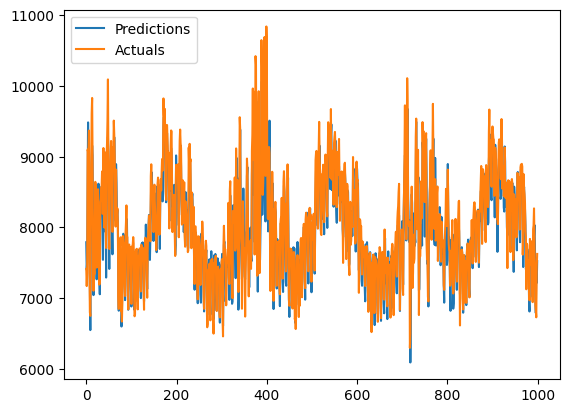

MAPE: 2.58%
RMSE: 292.44
MAE : 209.59


Predictions      Actuals
0     7790.062500  7412.811667
1     7399.592773  7171.183125
2     7512.180664  7350.264167
3     8400.333008  9098.258333
4     9483.486328  9070.002917
...           ...          ...
1084  8084.024902  8447.030417
1085  8835.605469  8771.408958
1086  8551.505859  8487.014792
1087  8367.106445  8380.489792
1088  8838.782227  8437.980833

[1089 rows x 2 columns]

In [ ]:
model28 = load_model('model28.keras')

predictions_plot(model28, X_train28, y_train28, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


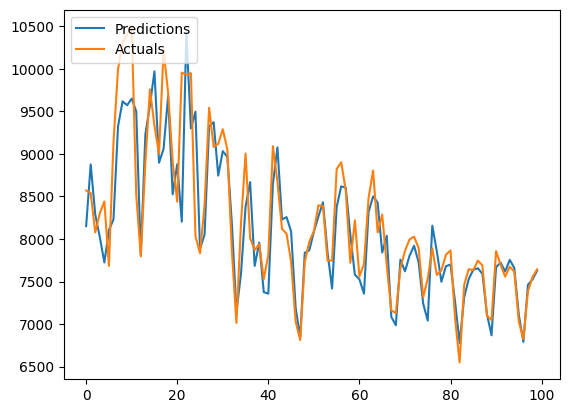

MAPE: 2.91%
RMSE: 337.95
MAE : 233.92


Predictions      Actuals
0    8151.791504  8569.568125
1    8876.126953  8540.904167
2    8287.166992  8076.513125
3    8023.371094  8302.971875
4    7724.350586  8440.820000
..           ...          ...
353  7659.905762  7508.199792
354  7659.757812  7694.271458
355  8273.290039  7746.240833
356  8803.038086  8321.401042
357  8619.822266  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model28, X_test28, y_test28, 0, 100)

## Explore Temp^2 ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data29 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train29, y_train29 = data29['train']
X_test29, y_test29 = data29['test']

i = X_train29.shape[1]
j = X_train29.shape[2]

In [ ]:
model29 = Sequential()
model29.add(InputLayer((i, j)))
model29.add(LSTM(32, dropout=0.013, recurrent_dropout=0.013))
model29.add(Dense(8, 'tanh'))
model29.add(Dense(1, 'linear'))

model29.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp29 = ModelCheckpoint('model29.keras', monitor='loss', save_best_only=True)
model29.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history29 = model29.fit(X_train29, y_train29, epochs=100, batch_size=8, callbacks=[cp29])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.1162 - root_mean_squared_error: 0.3175
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0091 - r

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


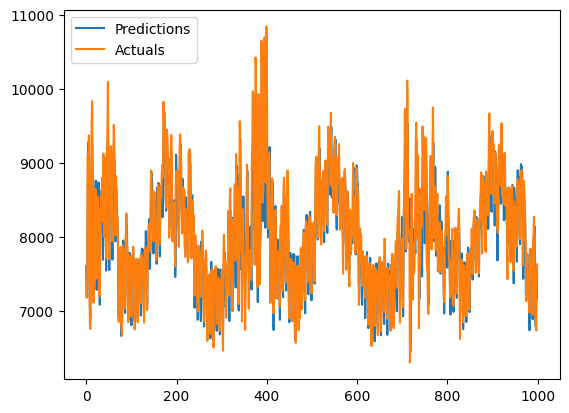

MAPE: 2.69%
RMSE: 315.14
MAE : 218.76


Predictions      Actuals
0     7600.681641  7412.811667
1     7204.310547  7171.183125
2     7183.420410  7350.264167
3     8233.845703  9098.258333
4     9273.141602  9070.002917
...           ...          ...
1084  8015.438965  8447.030417
1085  8548.032227  8771.408958
1086  8258.683594  8487.014792
1087  7853.937500  8380.489792
1088  8624.721680  8437.980833

[1089 rows x 2 columns]

In [ ]:
model29 = load_model('model29.keras')

predictions_plot(model29, X_train29, y_train29, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


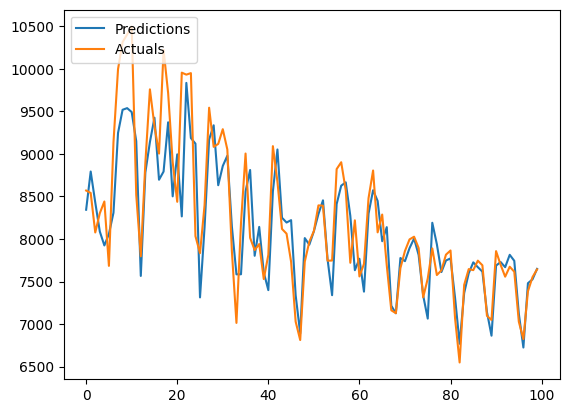

MAPE: 2.90%
RMSE: 338.73
MAE : 233.78


Predictions      Actuals
0    8343.940430  8569.568125
1    8793.055664  8540.904167
2    8429.558594  8076.513125
3    8088.101562  8302.971875
4    7924.238770  8440.820000
..           ...          ...
353  7772.340332  7508.199792
354  7590.548340  7694.271458
355  7658.742676  7746.240833
356  8401.668945  8321.401042
357  8343.976562  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model29, X_test29, y_test29, 0, 100)

## Recurrent Optuna Trial w/ temp^2 ##

In [ ]:
'''study4 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study4.optimize(objective4, n_trials=100)'''

"study4 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy4.optimize(objective4, n_trials=100)"

In [ ]:
'''print("Best trial:")
trial3 = study4.best_trial

print(f"  MAE: {trial4.value:.2f}")
print("  Params:")
for key, value in trial4.params.items():
    print(f"    {key}: {value}")'''

## Temp^2/Recurrent Dropout (Post Optuna) ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data30 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train30, y_train30 = data30['train']
X_test30, y_test30 = data30['test']

i = X_train30.shape[1]
j = X_train30.shape[2]
print(i)

7


In [ ]:
model30 = Sequential()
model30.add(InputLayer((i, j)))
model30.add(LSTM(64, dropout=0.00145, recurrent_dropout=0.3))
model30.add(Dense(8, 'tanh'))
model30.add(Dense(1, 'linear'))

model30.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp30 = ModelCheckpoint('model30.keras', monitor='loss', save_best_only=True)
model30.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history30 = model30.fit(X_train30, y_train30, epochs=100, batch_size=32, callbacks=[cp30])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0568 - root_mean_squared_error: 0.2311
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0105 - root_mean_squared_error: 0.1027
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0085 - root_mean_squared_error: 0.0920
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0078 - root_mean_squared_err

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


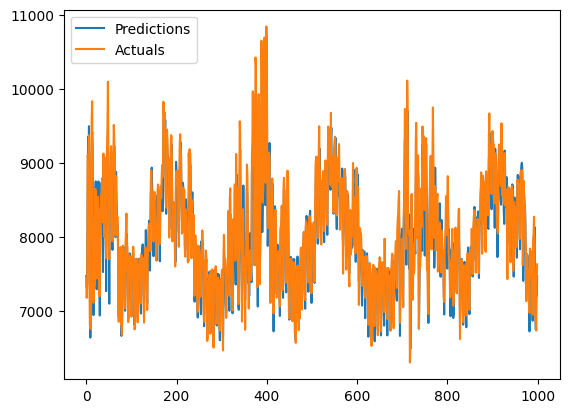

MAPE: 2.45%
RMSE: 272.84
MAE : 198.48


Predictions      Actuals
0     7468.360840  7412.811667
1     7314.210449  7171.183125
2     7360.025879  7350.264167
3     8425.709961  9098.258333
4     9348.578125  9070.002917
...           ...          ...
1084  8114.929199  8447.030417
1085  8953.752930  8771.408958
1086  8365.438477  8487.014792
1087  7998.950195  8380.489792
1088  8328.698242  8437.980833

[1089 rows x 2 columns]

In [ ]:
model30 = load_model('model30.keras')

predictions_plot(model30, X_train30, y_train30, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


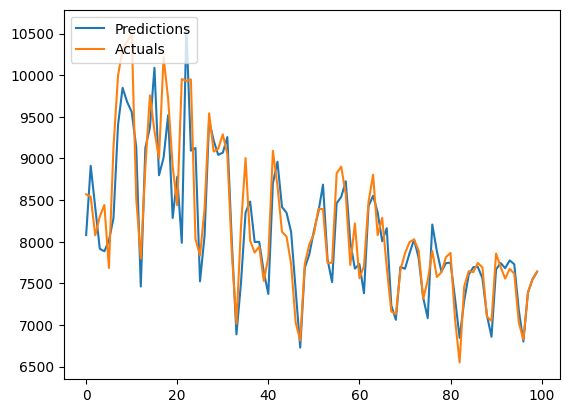

MAPE: 2.80%
RMSE: 326.71
MAE : 225.60


Predictions      Actuals
0    8079.834961  8569.568125
1    8911.959961  8540.904167
2    8409.374023  8076.513125
3    7915.001953  8302.971875
4    7884.600098  8440.820000
..           ...          ...
353  7575.360840  7508.199792
354  7481.597168  7694.271458
355  7966.688477  7746.240833
356  8585.177734  8321.401042
357  8196.474609  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model30, X_test30, y_test30, 0, 100)

## Test Attention ##

In [ ]:
@register_keras_serializable(package="Custom")
class SimpleAttention(Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)  # attention weights
        context = tf.reduce_sum(x * a, axis=1)
        if self.return_attention:
            return [context, a]   # return both if requested
        return context

    def get_config(self):
        config = super(SimpleAttention, self).get_config()
        config.update({"return_attention": self.return_attention})
        return config

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data31 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train31, y_train31 = data31['train']
X_test31, y_test31 = data31['test']

i = X_train31.shape[1]
j = X_train31.shape[2]

In [ ]:
inputs = Input(shape=(i, j))  # i = window_size, j = features
lstm_out = LSTM(64, return_sequences=True,
                dropout=0.00145, recurrent_dropout=0.3)(inputs)

context, att_weights = SimpleAttention(return_attention=True)(lstm_out)
dense = Dense(8, activation='tanh')(context)
outputs = Dense(1, activation='linear')(dense)

model31 = Model(inputs, outputs)

In [ ]:
cp31 = ModelCheckpoint('model31.keras', monitor='loss', save_best_only=True)
model31.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history31 = model31.fit(X_train31, y_train31, epochs=100, batch_size=32, callbacks=[cp31])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0360 - root_mean_squared_error: 0.1854
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0149 - root_mean_squared_error: 0.1220
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0113 - root_mean_squared_err

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


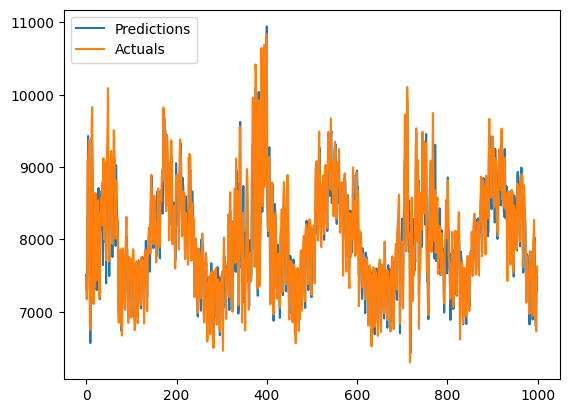

MAPE: 2.40%
RMSE: 266.47
MAE : 192.35


Predictions      Actuals
0     7515.450684  7412.811667
1     7304.667969  7171.183125
2     7568.829590  7350.264167
3     8545.756836  9098.258333
4     9429.023438  9070.002917
...           ...          ...
1084  8297.058594  8447.030417
1085  8779.984375  8771.408958
1086  8527.256836  8487.014792
1087  8238.910156  8380.489792
1088  8690.482422  8437.980833

[1089 rows x 2 columns]

In [ ]:
model31 = load_model('model31.keras')

predictions_plot(model31, X_train31, y_train31, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


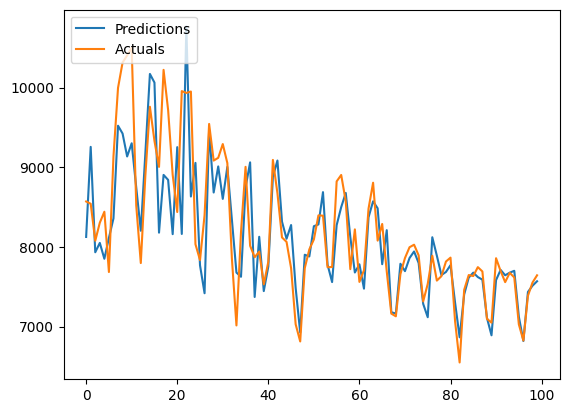

MAPE: 3.27%
RMSE: 381.43
MAE : 263.13


Predictions      Actuals
0    8124.519531  8569.568125
1    9255.079102  8540.904167
2    7932.050781  8076.513125
3    8049.690430  8302.971875
4    7850.251465  8440.820000
..           ...          ...
353  7813.898926  7508.199792
354  7589.037598  7694.271458
355  8367.895508  7746.240833
356  8645.111328  8321.401042
357  8200.765625  8503.726875

[358 rows x 2 columns]

In [ ]:
predictions_plot(model31, X_test31, y_test31, 0, 100)

In [ ]:
# Grab the LSTM output
lstm_out = model31.get_layer("lstm_45").output

# Reuse attention with return_attention=True
att_layer = SimpleAttention(return_attention=True, name="att_probe")
context, att_weights = att_layer(lstm_out)

probe_model = tf.keras.Model(inputs=model31.input, outputs=[context, att_weights])

# Now run it
ctx_all, weights_all = probe_model.predict(X_test31)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


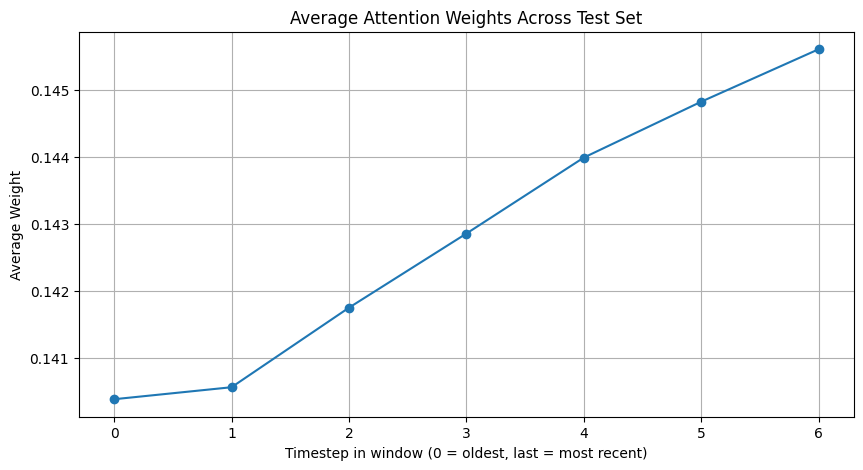

In [ ]:
avg_weights = np.mean(weights_all.squeeze(), axis=0)

plt.figure(figsize=(10,5))
plt.plot(range(len(avg_weights)), avg_weights, marker='o')
plt.title("Average Attention Weights Across Test Set")
plt.xlabel("Timestep in window (0 = oldest, last = most recent)")
plt.ylabel("Average Weight")
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm

# Assuming y_train31 or y_full is your demand series
acf_vals = sm.tsa.acf(y_train31, nlags=window_size)  # up to your lookback length


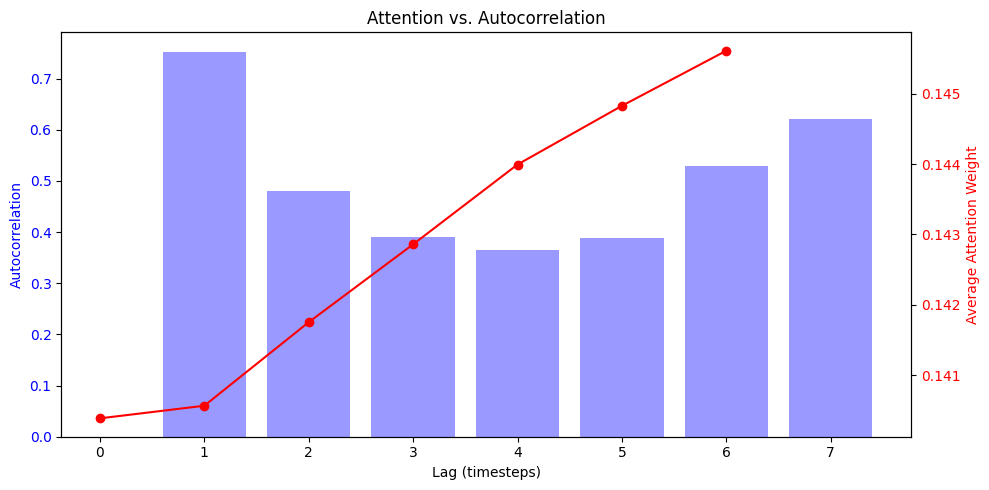

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Plot autocorrelation
ax1.bar(range(1, window_size+1), acf_vals[1:], alpha=0.4, color='blue', label='ACF')
ax1.set_xlabel("Lag (timesteps)")
ax1.set_ylabel("Autocorrelation", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot attention weights on secondary axis
ax2 = ax1.twinx()
ax2.plot(range(window_size), avg_weights, color='red', marker='o', label='Attention Weight')
ax2.set_ylabel("Average Attention Weight", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Attention vs. Autocorrelation")
fig.tight_layout()
plt.show()

In [ ]:
acf_lags = acf_vals[1:window_size+1]   # drop lag 0
corr = np.corrcoef(avg_weights, acf_lags)[0,1]
print(f"Correlation between attention weights and ACF: {corr:.3f}")

Correlation between attention weights and ACF: -0.108


In [ ]:
scaler = MinMaxScaler()

acf_scaled = scaler.fit_transform(acf_lags.reshape(-1,1)).flatten()
att_scaled = scaler.fit_transform(avg_weights.reshape(-1,1)).flatten()

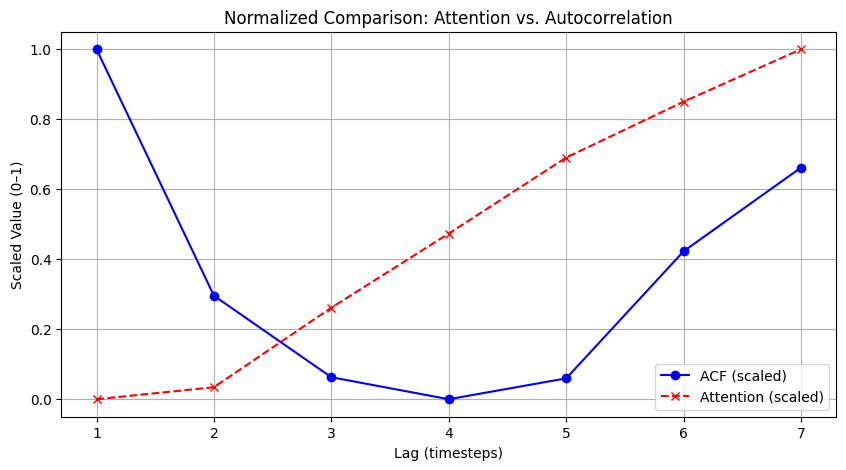

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(1, window_size+1), acf_scaled, marker='o', color='blue', label='ACF (scaled)')
plt.plot(range(1, window_size+1), att_scaled, marker='x', color='red', linestyle='--', label='Attention (scaled)')
plt.title("Normalized Comparison: Attention vs. Autocorrelation")
plt.xlabel("Lag (timesteps)")
plt.ylabel("Scaled Value (0–1)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import spearmanr

rho, pval = spearmanr(avg_weights, acf_lags)
print(f"Spearman correlation: {rho:.3f}, p-value: {pval:.3f}")

Spearman correlation: -0.071, p-value: 0.879
